In [165]:
 %load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [167]:
import bokeh
import time
import copy
import scipy.stats as ss
from scipy.optimize import curve_fit
from coffea import hist, processor, nanoevents, util
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema

import awkward as ak
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState

from dask.distributed import Client
import inspect
import matplotlib.pyplot as plt
import matplotlib as mpl

from pltStyle import pltStyle
import os
# %matplotlib notebook 
# %matplotlib notebook 

### Import processor

In [168]:
from CoffeaJERCProcessor_L5 import Processor

Parameters of the run

In [169]:
UsingDaskExecutor = True
CoffeaCasaEnv     = False
load_preexisting  = True    ### True if don't repeat the processing of files and use preexisting JER from output
test_run          = True     ### True if run only on one file
load_fit_res      = True

tag = '_L5'

exec('from CoffeaJERCProcessor'+tag+' import Processor') 

add_tag = '_Herwig_TTBAR' #'_QCD' # '_testing_19UL18' # ''
tag_full = tag+add_tag

outname = 'out/CoffeaJERCOutputs'+tag_full+'.coffea'
outname = outname+'_test' if test_run else outname

if load_preexisting == True:
    UsingDaskExecutor = False
    
if not os.path.exists("out"):
    os.mkdir("out")
    
if not os.path.exists("out_txt"):
    os.mkdir("out_txt")
    
if test_run and not os.path.exists("test"):
    os.mkdir("test/")
    os.mkdir("test/out_txt")
    os.mkdir("test/fig")

In [170]:
## assume running on the LPC
xrootdstr = 'root://cmsxrootd.fnal.gov/'
# assume running on the lxplus
# xrootdstr = 'root://cms-xrd-global.cern.ch//'

# if running on coffea casa instead...
if CoffeaCasaEnv:
    xrootdstr = 'root://xcache/'
    
dataset = 'fileNames_QCD20UL18.txt'
dataset = 'fileNames_Herwig_20UL18.txt'
# dataset = 'fileNames_TTToSemi20UL18.txt'
# dataset = 'dataset.txt'


rootfiles = open(dataset).read().split()

fileslist = [xrootdstr + file for file in rootfiles]
fileslist = fileslist[:40] # if add_tag=='QCD' else fileslist # :20 to skim the events

/tmp/anpotreb/ipykernel_31327/2528088220.py:16: ResourceWarning: unclosed file <_io.TextIOWrapper name='fileNames_Herwig_20UL18.txt' mode='r' encoding='UTF-8'>
  rootfiles = open(dataset).read().split()


In [171]:
# to test on one file, uncomment the line below

fileslist = fileslist
if test_run:
    fileslist = [fileslist[0]]
    ### The smallest file in the RunIISummer20UL18NanoAODv9 dataset
#     fileslist = ['root://cms-xrd-global.cern.ch//'+
#                  '/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/792B4CD3-A001-F94F-9AAB-D74D532DE610.root']
# fileslist


Test if certificate works opening the file

In [172]:
import os
### RUN THIS CELL ONLY IF YOU ARE USING SWAN 

##### REMEMBER TO MANUALLY COPY THE PROXY TO YOUR CERNBOX FOLDER AND TO MODIFY THE NEXT LINE
os.environ['X509_USER_PROXY'] = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'
if os.path.isfile(os.environ['X509_USER_PROXY']):
    print("Found proxy at {}".format(os.environ['X509_USER_PROXY']))
else:
    print("os.environ['X509_USER_PROXY'] ",os.environ['X509_USER_PROXY'])
os.environ['X509_CERT_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/certificates'
os.environ['X509_VOMS_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/vomsdir'

Found proxy at /afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem


In [173]:
import uproot

In [174]:
ff = uproot.open(fileslist[0])
ff.keys()
ff.close()

['tag;1',
 'Events;1',
 'LuminosityBlocks;1',
 'Runs;1',
 'MetaData;1',
 'ParameterSets;1']

# Dask Setup:
---
### For Coffea-Casa, the client must be specified according to the user that is logged into the Coffea-Casa Environment.
#### 1.) go to the left of this coffea-casa session to the task bar and click the orange-red button; it will say "Dask" if you hover your cursor over it
#### 2.) scroll down to the blue box where it shows the "Scheduler Address"
#### 3.) write that full address into the dask Client function 
#### Example: `client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")`
---
### For CMSLPC, the client must be specified with the LPCCondorCluster
#### 1.) follow installation instructions from https://github.com/CoffeaTeam/lpcjobqueue, if you have not already done so, to get a working singularity environment with access to lpcjobqueue and LPCCondorCluster class
#### 2.) import LPCCondorCluster: `from lpcjobqueue import LPCCondorCluster`
#### 3.) define the client
#### Example: 
`cluster = LPCCondorCluster()`

`client = Client(cluster)`


In [175]:
# Dask set up for Coffea-Casa only
if(UsingDaskExecutor and CoffeaCasaEnv):
    client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")
    client.upload_file('CoffeaJERCProcessor.py')

In [176]:
# Dask set up for LPC only 
if(UsingDaskExecutor and not CoffeaCasaEnv):
#     from lpcjobqueue import LPCCondorCluster
#     cluster = LPCCondorCluster()
#     cluster.adapt(minimum=1, maximum=10)
#     client = Client(cluster)
#     client.upload_file('CoffeaJERCProcessor.py')
    
    
    from dask.distributed import Client
#     client=Client()
#     cluster.adapt(minimum=1, maximum=10)
    client = Client()
    client.upload_file('CoffeaJERCProcessor'+tag+'.py')
# client

In [177]:
# dataset_axis = hist.Cat("dataset", "Primary dataset")
# cats_axis = hist.Cat("anacat", "Analysis Category")

# jetpt_axis = hist.Bin("pt", r"$p_T$", ptbins)
# ptresponse_axis = hist.Bin("ptresponse", "RECO / GEN response", 100, 0, 5)
# jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
# jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", etabins)
# jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -np.pi, np.pi)

In [178]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
Chunk = [10000, 5] # [chunksize, maxchunks]

filesets = {'QCD': fileslist}

if not load_preexisting:
    for name,files in filesets.items(): 
        if not UsingDaskExecutor:
            chosen_exec = 'futures'
            output = processor.run_uproot_job({name:files},
                                              treename='Events',
                                              processor_instance=Processor(),
                                              executor=processor.iterative_executor,
        #                                        executor=processor.futures_executor,
                                              executor_args={
                                                  'skipbadfiles':False,
                                                  'schema': NanoAODSchema, #BaseSchema
                                                  'workers': 2},
                                              chunksize=Chunk[0])#, maxchunks=Chunk[1])
        else:
            chosen_exec = 'dask'
            output = processor.run_uproot_job({name:files},
                                              treename='Events',
                                              processor_instance=Processor(),
                                              executor=processor.dask_executor,
                                              executor_args={
                                                  'client': client,
                                                  'skipbadfiles':False,
                                                  'schema': NanoAODSchema, #BaseSchema
    #                                               'workers': 2
                                              },
                                              chunksize=Chunk[0])#, maxchunks=Chunk[1])

    elapsed = time.time() - tstart
    outputs_unweighted[name] = output
    util.save(output, outname)
    outputs_unweighted[name] = output
    print(name + ' unweighted output loaded')
else:
    # output = util.load('out/CoffeaJERCOutputs_binned.coffea')
    output = util.load(outname)
    
elapsed = time.time() - tstart

### Fit responses

define gaussian function for fitting the responses

In [179]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

Define some global variables for the fit

In [180]:
f_xvals = np.linspace(0,5,5001)
ptbins = output['ptresponse'].axis('pt').edges()
etabins = output['ptresponse'].axis('jeteta').edges()
jetpt_length = len(ptbins)-1
jeteta_length = (len(etabins)-1)//2

etabins_mod = etabins[(len(etabins)-1)//2:]

ptresp_edd = output['ptresponse'].axis('ptresponse').edges()
plot_pt_edges = ptresp_edd[0:np.nonzero(ptresp_edd>=2.0)[0][0]]
hist_pt_edges = plot_pt_edges[1:-1]   #for plotting. To exclude overflow from the plot
plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

In [181]:
from pltStyle import pltStyle
pltStyle(style='paper')
plt.rcParams['figure.subplot.left'] = 0.162
plt.rcParams['figure.dpi'] = 150

In [182]:
import warnings
# warnings.filterwarnings('ignore') ### To suppress warnings with bad 


# xvals = output['ptresponse'+samp].axis('ptresponse').centers()

# FitFigDir = 'fig/response_pt_eta'+samp+tag
# if not os.path.exists(FitFigDir):
#     os.mkdir(FitFigDir)

def fit_responses(output, samp='_b'):
    warnings.filterwarnings('ignore')

    mean = np.zeros((jetpt_length, jeteta_length))
    median = np.zeros((jetpt_length, jeteta_length))
    width = np.zeros((jetpt_length, jeteta_length))
    chi2s = np.zeros((jetpt_length, jeteta_length))
    meanvar = np.zeros((jetpt_length, jeteta_length))
#     idx = []
    
    N_converge = 0
    N_not_converge = 0

    FitFigDir = 'fig/response_pt_eta'+samp+tag_full
    print("Images will be saved under ", FitFigDir)
    if not os.path.exists(FitFigDir):
        os.mkdir(FitFigDir)
        
    xvals = output['ptresponse'+samp].axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
    f_xvals = np.linspace(0,5,5001)


    for i in range(len(ptbins)-1):
        ptBin = hist.Interval(ptbins[i], ptbins[i+1])
        print('-'*25)
        print('-'*25)
        
        if not 'inf' in str(ptBin):
            pt_string = '_pT'+str(int(ptBin.lo))+'to'+str(int(ptBin.hi))
        else:
            pt_string = '_pT'+str(ptBin.lo) + 'to' + str(ptBin.hi)
            pt_string = pt_string.replace('.0','').replace('-infto','0to')

        for k in range(jeteta_length):
            etaBinPl = hist.Interval(etabins[k+jeteta_length], etabins[k+1+jeteta_length])
            etaBinMi = hist.Interval(etabins[jeteta_length-k-1], etabins[jeteta_length-k])
#             etaBin = hist.Interval(etabins[k], etabins[k+1])
            print("etaBin = ", etaBinPl ,", ptBin = ", ptBin )
            eta_string = '_eta'+str(etaBinPl.lo)+'to'+str(etaBinPl.hi)
            eta_string = eta_string.replace('.','')
            
            # The name integrate is a bit misleasding in this line. Is there another way to "slice" a histogram? //Andris
            histoMi = output['ptresponse'+samp].integrate('jeteta', etaBinMi).integrate('pt', ptBin)
            histoPl = output['ptresponse'+samp].integrate('jeteta', etaBinPl).integrate('pt', ptBin)
            histo = (histoMi+histoPl)
            histvals = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))
            yvals = histo.values()[('QCD',)][1:]  #[1:] to exclude the second peak for low pt

            N = histo.integrate('ptresponse').values()[('QCD',)]
            nonzero_bins = np.sum(yvals>0)
            if nonzero_bins<2 or N<50:
                p2=[0,0,0]
                chi2 = np.nan
                arr = np.array([[np.nan]*3]*3)
                Ndof = 0
                print("Too little data points, skipping p = ", p2)
            else:
                try:
                    p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
                    N_converge += 1
                                ### Second Gaussian
                    xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
                    xfit_h = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0][0]
                    if len(range(xfit_l,xfit_h))<6: #if there are only 3pnts, the uncertainty is infty
                        xfit_l = xfit_l-1
                        xfit_h = xfit_h+1
                        if len(range(xfit_l,xfit_h))<6:
                            xfit_l = xfit_l-1
                            xfit_h = xfit_h+1
                    xvals2 = xvals[xfit_l: xfit_h]
                    yvals2 = yvals[xfit_l: xfit_h]
                    p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)

                    ygaus = gauss(xvals, *p2)
                    chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
                    Ndof = len(xvals2)-3
                    if chi2<50000:
#                         pass
                        print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
                    else:
                        print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
                except(RuntimeError):
                    p2=[0,0,0]
                    print("Fit failed because of non-convergance, p = ", p2)
                    chi2 = np.nan
                    arr = np.array([[np.nan]*3]*3)
                    Ndof = 0
                    N_not_converge += 1
                    continue


#             fgaus = gauss(f_xvals, *p)
            fgaus2 = gauss(f_xvals, *p2)

            median[i,k] = np.median(histvals)
            mean[i,k] = p2[1] # - (scal-1)
            width[i,k] = p2[2]
            chi2s[i,k] = chi2
            meanvar[i,k] = arr[1,1]
#             idx.append(i)

   ####################### Plotting ############################
            if not test_run:
                histo = histo.rebin('ptresponse', plot_response_axis)

                fig, ax2 = plt.subplots();
                hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
                            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
                # ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
                ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
                ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
                ax2.set_xlim(plot_pt_edges[[0,-1]])
                h = ax2.get_ylim()[1]/1.05
                plt.text(0.03,0.95*h,'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1],np.sqrt(arr[1,1])))
                plt.text(0.03,0.88*h,'Width {0:0.3f}$\pm${1:0.3f}'.format(p2[2],np.sqrt(arr[2,2])))
                plt.text(0.03,0.81*h,'Median {0:0.3f}'.format(np.median(histvals)))
                plt.text(0.03,0.73*h,'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
                plt.text(0.03,0.66*h,'N data = {0:0.3g}'.format(N))
                ax2.legend();

                plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
                plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
                plt.close();                

    warnings.filterwarnings('default')
    print("N converge = ", N_converge, "N_not_converge = ", N_not_converge );
    warnings.filterwarnings('default')
    
    return [mean, width, median, chi2s, meanvar]
    

<>:124: DeprecationWarning: invalid escape sequence \p
<>:125: DeprecationWarning: invalid escape sequence \p
<>:127: DeprecationWarning: invalid escape sequence \c
<>:124: DeprecationWarning: invalid escape sequence \p
<>:125: DeprecationWarning: invalid escape sequence \p
<>:127: DeprecationWarning: invalid escape sequence \c
/tmp/anpotreb/ipykernel_31327/2507239245.py:124: DeprecationWarning: invalid escape sequence \p
  plt.text(0.03,0.95*h,'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1],np.sqrt(arr[1,1])))
/tmp/anpotreb/ipykernel_31327/2507239245.py:125: DeprecationWarning: invalid escape sequence \p
  plt.text(0.03,0.88*h,'Width {0:0.3f}$\pm${1:0.3f}'.format(p2[2],np.sqrt(arr[2,2])))
/tmp/anpotreb/ipykernel_31327/2507239245.py:127: DeprecationWarning: invalid escape sequence \c
  plt.text(0.03,0.73*h,'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))


In [183]:
df_csv = pd.read_csv('out_txt/Closure_L5_QCD.csv').set_index('etaBins')
closure_corr = df_csv.to_numpy().transpose()
closure_corr = np.pad(closure_corr,1,constant_values=1)

In [184]:
def plot_corrections(mean, samp, meanvar):
    ### To ignore the points with 0 on y axis when setting the y axis limits
    mean_p = mean.copy()
    mean_p[mean_p==0] = np.nan

    # h = np.max(histo.values()[('QCD',)])
    fig, ax = plt.subplots()
    start = 17
    
#     etabins_mod = np.flip(etabins[(len(etabins)-1)//2:])
    
#     k1 = np.where(etabins<=-1.3)[0][-1]
    k2 = np.where(etabins_mod<=0)[0][-1]
#     k3 = np.where(etabins<=-2.5)[0][-1]
    k4 = np.where(etabins_mod<=1.3)[0][-1]
#     k5 = np.where(etabins<=-3)[0][-1]
    k6 = np.where(etabins_mod<=2.5)[0][-1]
#     k7 = np.where(etabins<=-5)[0][-1]
    k8 = np.where(etabins_mod<=3.0)[0][-1]
#     print("mean_p = ", mean_p[start:,k2])
#     print("mean_p = ", mean[start:,k2])

#     print("Shapes = ", ptbins.shape, mean_p.shape, meanvar.shape  )
    
    # ax.plot(ptbins[start:],mean_p[start:,k0], 'o', label=f'${etabins[k0]}<\eta<{etabins[k0+1]}$')
#     plt.errorbar(ptbins[start:],mean_p[start:,k1], yerr=np.sqrt(meanvar[start:,k1]), marker='o',
#                  linestyle="none", label=f'${etabins[k1]}<\eta<{etabins[k1+1]}$')
    plt.errorbar(ptbins[start:-1],mean_p[start:,k2], yerr=np.sqrt(meanvar[start:,k2]), marker='o',
                 linestyle="none", label=f'${etabins_mod[k2]}<\eta<{etabins_mod[k2+1]}$')
#     plt.errorbar(ptbins[start:],mean_p[start:,k3], yerr=np.sqrt(meanvar[start:,k3]), marker='o',
#                  linestyle="none", label=f'${etabins[k3]}<\eta<{etabins[k3+1]}$')
    plt.errorbar(ptbins[start:-1],mean_p[start:,k4], yerr=np.sqrt(meanvar[start:,k4]), marker='o',
             linestyle="none", label=f'${etabins_mod[k4]}<\eta<{etabins_mod[k4+1]}$')
#     plt.errorbar(ptbins[start:],mean_p[start:,k5], yerr=np.sqrt(meanvar[start:,k5]), marker='o',
#                  linestyle="none", label=f'${etabins[k5]}<\eta<{etabins[k5+1]}$')
    plt.errorbar(ptbins[start:-1],mean_p[start:,k6], yerr=np.sqrt(meanvar[start:,k6]), marker='o',
             linestyle="none", label=f'${etabins_mod[k6]}<\eta<{etabins_mod[k6+1]}$')
#     plt.errorbar(ptbins[start:],mean_p[start:,k7], yerr=np.sqrt(meanvar[start:,k7]), marker='o',
#              linestyle="none", label=f'${etabins[k7]}<\eta<{etabins[k7+1]}$')
    plt.errorbar(ptbins[start:-1],mean_p[start:,k8], yerr=np.sqrt(meanvar[start:,k8]), marker='o',
             linestyle="none", label=f'${etabins_mod[k8]}<\eta<{etabins_mod[k8+1]}$')
# ax.plot(ptbins[start:],mean_p[start:,k2], 'o', label=f'${etabins[k2]}<\eta<{etabins[k2+1]}$')
    # ax.plot(ptbins[start:],mean_p[start:,k3], 'o', label=f'${etabins[k3]}<\eta<{etabins[k3+1]}$')

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
    y_norm = np.concatenate([mean_p[start:,[k2, k4, k6, k8]]])
#     print("ynorm = ", y_norm)
#     print("yerr = ", yerr_norm)
    norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
#     print("(yerr_norm+y_norm)[norm_pos]) = ", (yerr_norm+y_norm)[norm_pos])
    ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))
#     ax.set_ylim(0.988 , 1.011)
    
    ax.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(r'mean response');
    ax.set_xscale('log')
    # ax.set_ylim([0.8,1.1])
    ax.legend()
    if test_run:
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
    else:
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.png');

    plt.show();
    
# plotCorrections()

<>:29: DeprecationWarning: invalid escape sequence \e
<>:33: DeprecationWarning: invalid escape sequence \e
<>:37: DeprecationWarning: invalid escape sequence \e
<>:41: DeprecationWarning: invalid escape sequence \e
<>:29: DeprecationWarning: invalid escape sequence \e
<>:33: DeprecationWarning: invalid escape sequence \e
<>:37: DeprecationWarning: invalid escape sequence \e
<>:41: DeprecationWarning: invalid escape sequence \e
/tmp/anpotreb/ipykernel_31327/584020382.py:29: DeprecationWarning: invalid escape sequence \e
  linestyle="none", label=f'${etabins_mod[k2]}<\eta<{etabins_mod[k2+1]}$')
/tmp/anpotreb/ipykernel_31327/584020382.py:33: DeprecationWarning: invalid escape sequence \e
  linestyle="none", label=f'${etabins_mod[k4]}<\eta<{etabins_mod[k4+1]}$')
/tmp/anpotreb/ipykernel_31327/584020382.py:37: DeprecationWarning: invalid escape sequence \e
  linestyle="none", label=f'${etabins_mod[k6]}<\eta<{etabins_mod[k6+1]}$')
/tmp/anpotreb/ipykernel_31327/584020382.py:41: DeprecationWar

In [185]:
def save_data(data, name, samp):
    # data = {str(ptBin):mean[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
    data_dict = {str(ptBin):data[i] for i, ptBin in enumerate(ptbins[:-1])}

    # data['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
    data_dict['etaBins'] = np.array([str(etaBin) for etaBin in etabins_mod[:-1]])

    df = pd.DataFrame(data=data_dict)
    df = df.set_index('etaBins')
    if not test_run:
        df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
    else:
        df.to_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv')
#     return df

In [186]:
def read_data(name, samp):
    if not test_run:
        df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
    else: #before_closure/
        df_csv = pd.read_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+tag+'_test.csv')
    
#     df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5.csv').set_index('etaBins')
    data = df_csv.to_numpy().transpose()
    return data

### Run fitting for each sample

-------------------------
-------------------------
Fitting subsample:  


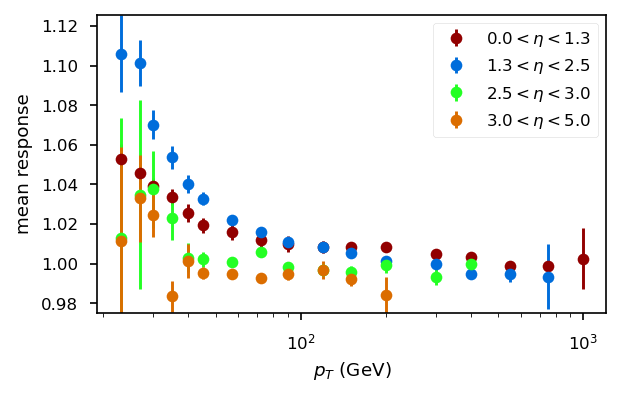

-------------------------
-------------------------
Fitting subsample:  _b


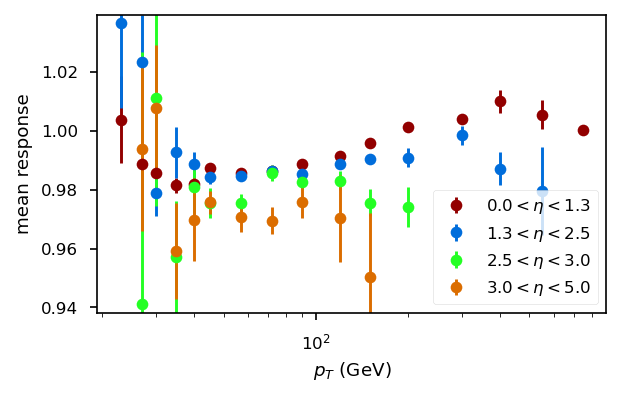

In [188]:
# load_fit_res=True
subsamples = ['', '_b', '_c', '_l', '_g']
subsamples = ['', '_b']
for samp in subsamples:
    print('-'*25)
    print('-'*25)
    print('Fitting subsample: ', samp)
    if load_fit_res:
        mean = read_data("Mean", samp)
        meanvar = read_data("MeanVar", samp)
#         width = read_data("Width")
#         median = read_data(median, "Median")
    else:
        mean, width, median, chi2s, meanvar = fit_responses(output, samp)
        for data, name in zip([mean, width, median, meanvar],["Mean", "Width", "Median", "MeanVar"]):
            save_data(data, name, samp)
            
    plot_corrections(mean, samp, meanvar)

### Fitting the mean responses

In [189]:
samp = '_b'
etabin = 1

mean = read_data("Mean", samp)
meanvar = read_data("MeanVar", samp)

In [190]:
means = mean[:, etabin]
means2fit = means[means!=0.0]
ptbins2fit = ptbins[:-1][means!=0.0]
meanvar2fit = np.abs(meanvar[means!=0.0,etabin])

xvals = np.linspace(ptbins2fit.min() - (0.5), ptbins2fit.max()+(ptbins2fit[-1]-ptbins2fit[-11]),1000)

In [191]:
import scipy as sp

In [192]:
def ptscale2int(x, ptbins):
    ptmax = max(np.log10(ptbins))
    ptmin = min(np.log10(ptbins))
    z = np.log10(x)
    return ((z-ptmin)-(ptmax-z))/(ptmax-ptmin);

# def int2pt(z, ptbins):
#     Mi = np.min(np.log10(ptbins))
#     Ma = np.max(np.log10(ptbins))
#     pts = z/2*(Ma-Mi) + (Ma + Mi)/2
#     return 10**pts

In [193]:
def sum_cheb_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) )
    return res

def sum_cheb5_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4, c5 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) + 
           c5 * sp.special.eval_chebyt(5, xs) )
    return res

def sum_cheb3_tmp(x, ptbins, *p):
    c0, c1, c2, c3 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) )
    return res

def sum_cheb2_tmp(x, ptbins, *p):
    c0, c1, c2 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) )
    return res

In [194]:
def response_fnc(x, *p):
    p0, p1, p2, p3, p4, p5 = p
    return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))
#     return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [195]:
# def response_fnc1(x, *p):
#     p0, p1, p2, p3, p4, p5 = p
#     return (p0+(p1/((np.log10(x)**2)+p2)))
# def response_fnc2(x, *p):
#     p0, p1, p2, p3, p4, p5 = p
#     return (p3*np.exp(-(p4*((np.log10(x)-p5)*(np.log10(x)-p5)))))
# #     return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [196]:
init_vals_2014 = {
    'b':
    [[0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258],
    [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878],
    [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314],
    [0.135913, 7.92441, 3.85698, -0.804604, 1.11911, 0.732041]],
    'c' :
    [[ 0.940259, 0.705481, 0.23917, -0.826926, 0.311473, -0.514041],
    [0.982083, 0.238007, 4.35924, -0.0314618, 5.91028, 1.67749],
    [0.733505, 7.26794, 12.2028, -0.756302, 0.0895257, -1.96324],
    [0.932305, 1.15954, 17.1731, -0.471313, 2.58424, 0.254917]],
    'g' :
    [[0.877892, 3.10194, 1.16568, -677.876, 0.0325026, -12.9485],
    [0.983775, 0.247943, 1.55373, -0.0254802, 3.35748, 1.71263],
    [-0.972548, 38.8683, 2.47151, -44.0233, 0.0901665, -3.15495],
    [1.0655, -0.0680325, -0.509038, -8.59434e+06, 42.6162, 0.357177]],
    'l':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],   
}

Better starting fit values I found

In [197]:
init_vals_2014['b'][0] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]
init_vals_2014['b'][3] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]

In [198]:
# init_vals_2014

In [199]:
# samp = '_c'
# etabin = 0

In [200]:
# subsamples = ['_b', '_c', '_l', '_g']
# subsamples = ['','_b', '_c', '_l', '_g']


In [201]:
# mean = read_data("Mean", samp)[:,etabin]
# meanvar = read_data("MeanVar", samp)[:,etabin]

# mean_range_pt = range(15,len(mean)-8)
# mean_range = mean_range_pt[:-1]

# ptbins2fit = ptbins[mean_range_pt]
# ptbins2fit = (ptbins2fit[:-1]+ptbins2fit[1:])/2
# means = mean[mean_range]

# means2fit = means[means!=0.0]
# ptbins2fit = ptbins2fit[means!=0.0]
# meanvar2fit = np.abs(meanvar[mean_range][means!=0.0])

In [202]:
def sum_cheb_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) )
    return res

In [204]:
# # for samp in subsamples:
# #     for etabin in range(4):
# samp = '_b'
# etabin = 3
# mean = read_data("Mean", samp)[:,etabin]
# meanvar = read_data("MeanVar", samp)[:,etabin]

# mean_range_pt = range(15,len(mean)-7)
# mean_range = mean_range_pt[:-1]

# ptbins2fit = ptbins[mean_range_pt]
# ptbins2fit = (ptbins2fit[:-1]+ptbins2fit[1:])/2
# means = mean[mean_range]

# means2fit = means[means!=0.0]
# ptbins2fit = ptbins2fit[means!=0.0]
# meanvar2fit = np.abs(meanvar[mean_range][means!=0.0])

# xvals = np.linspace(ptbins2fit.min() - (1), ptbins2fit.max()+(ptbins2fit[-1]-ptbins2fit[-11]),1000)
# def sum_cheb(x, *p):
#     return sum_cheb_tmp(x, ptbins2fit, *p)
# def sum_cheb5(x, *p):
#     return sum_cheb5_tmp(x, ptbins2fit, *p)    
# def sum_cheb3(x, *p):
#     return sum_cheb3_tmp(x, ptbins2fit, *p)  
# def sum_cheb2(x, *p):
#     return sum_cheb2_tmp(x, ptbins2fit, *p)  

# try:
#     p_resp, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=[ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]) # init_vals_2014[samp[-1:]][etabin]) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
#     p_resp_err, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=p_resp, sigma=np.sqrt(meanvar2fit))
# except(RuntimeError):
#     print("Winter 14 fit failed")
#     p_resp, p_resp_err = [[np.nan]*6]*2
# #      = np.nan*6

# # p_resp_err
# p_cheb1, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1])
# p_cheb, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=p_cheb1, sigma=np.sqrt(meanvar2fit))
# p_cheb5_1, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1, 1])
# p_cheb5, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=p_cheb5_1, sigma=np.sqrt(meanvar2fit))
# p_cheb3_1, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1])
# p_cheb3, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=p_cheb3_1, sigma=np.sqrt(meanvar2fit))
# p_cheb2_1, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=[ 1, 1, 1])
# p_cheb2, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=p_cheb2_1, sigma=np.sqrt(meanvar2fit))

# yvals_resp = response_fnc(xvals, *p_resp)
# yvals_resp_err = response_fnc(xvals, *p_resp_err)
# # yvals_resp_err = response_fnc(xvals, *[0.530002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258])
# yvals = sum_cheb(xvals, *p_cheb)
# #         yvals1 = sum_cheb(xvals, *p_cheb1)
# yvalsC5 = sum_cheb5(xvals, *p_cheb5)
# #         yvalsC5_1 = sum_cheb5(xvals, *p_cheb5_1)
# yvalsC3 = sum_cheb3(xvals, *p_cheb3)
# yvalsC2 = sum_cheb2(xvals, *p_cheb2)

# chi2_resp = np.sum((response_fnc(ptbins2fit, *p_resp_err) - means2fit)**2/meanvar2fit)
# chi2_C4 = np.sum((sum_cheb(ptbins2fit, *p_cheb) - means2fit)**2/meanvar2fit)
# chi2_C5 = np.sum((sum_cheb5(ptbins2fit, *p_cheb5) - means2fit)**2/np.abs(meanvar2fit))
# chi2_C3 = np.sum((sum_cheb3(ptbins2fit, *p_cheb3) - means2fit)**2/np.abs(meanvar2fit))
# chi2_C2 = np.sum((sum_cheb2(ptbins2fit, *p_cheb2) - means2fit)**2/np.abs(meanvar2fit))
# Ndof_C4 = len(ptbins2fit) - 5
# Ndof_C5 = len(ptbins2fit) - 6
# Ndof_C3 = len(ptbins2fit) - 4
# Ndof_C2 = len(ptbins2fit) - 3
# Ndof_resp = len(ptbins2fit) - 6


# fig, ax = plt.subplots()

# plt.errorbar(ptbins2fit, means2fit, yerr=np.sqrt(np.abs(meanvar2fit)), marker='o',
#              linestyle="none", label=f'Data {etabins_mod[etabin]}'+r'$<\eta<'+f'${etabins_mod[etabin+1]}')

# eta_string = '_eta'+str(etabins_mod[etabin])+'to'+str(etabins_mod[etabin+1])
# eta_string = eta_string.replace('.','')
# if np.isnan(chi2_resp): 
#     winter14_lab = 'Winter14 func, failed'
# else:
#     winter14_lab= 'Winter14 func, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_resp, Ndof_resp)

# # yvals_resp_err = response_fnc(xvals, *[ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03,
# #         2.99200015e+01,  1.21399356e+02])
# ax.plot(xvals, yvals_resp_err, label=winter14_lab, linewidth=1.8);
# ax.plot(xvals, yvals, label=r'Chebyshev, n=4, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C4, Ndof_C4),linewidth=1.8);
# #         ax.plot(xvals, yvalsC5, label=r'Chebyshev, n=5, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C5, Ndof_C5),linewidth=1.8);
# ax.plot(xvals, yvalsC3, label=r'Chebyshev, n=3, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C3, Ndof_C3),linewidth=1.8);
# ax.plot(xvals, yvalsC2, label=r'Chebyshev, n=2, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C2, Ndof_C2),linewidth=1.8);


# #         yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
# #         y_norm = np.concatenate([mean_p[start:,[k2, k4, k6, k8]]])
# #     print("ynorm = ", y_norm)
# #     print("yerr = ", yerr_norm)
# std = np.sqrt(np.abs(meanvar2fit))
# norm_pos = (std<0.1) &  (std != np.inf)
# #     print("(yerr_norm+y_norm)[norm_pos]) = ", (yerr_norm+y_norm)[norm_pos])
# ax.set_ylim(np.min((means2fit-std)[norm_pos])-0.002 ,np.max((std+means2fit)[norm_pos])+0.002)

# ax.set_xlabel(r'$p_T$ (GeV)');
# ax.set_ylabel(r'mean response');
# ax.set_xscale('log')
# # ax.set_ylim([0.8,1.1])
# ax.legend(prop={'size': 7})
# # plt.savefig('fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
# # plt.savefig('fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
# # fig.set_size_inches(6, 4, forward=True)
# plt.show();
# 'a';

Winter 14 fit failed


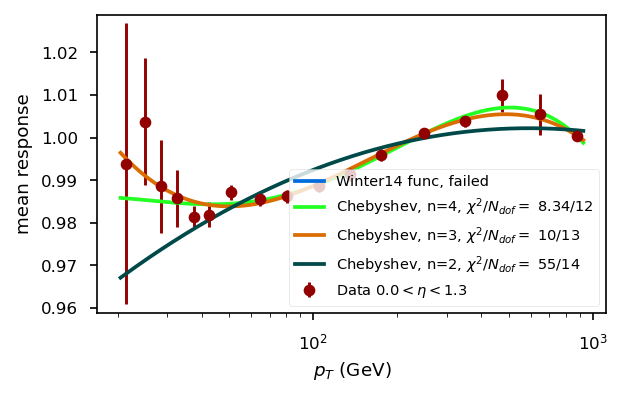

Winter 14 fit failed


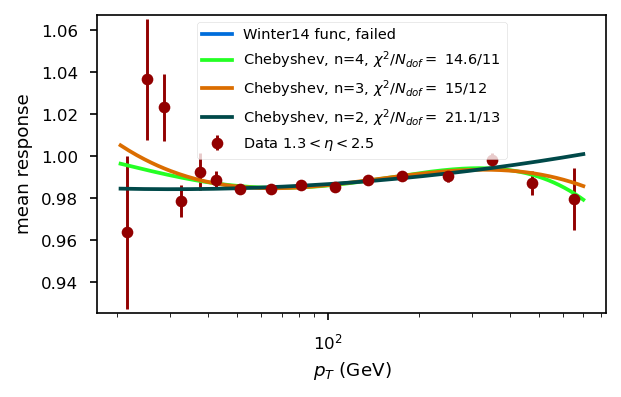

Winter 14 fit failed


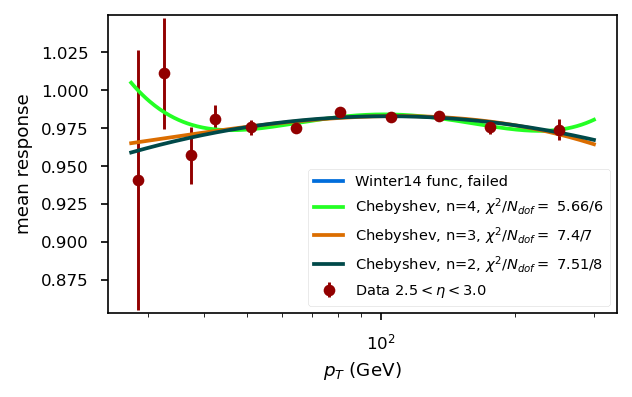

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


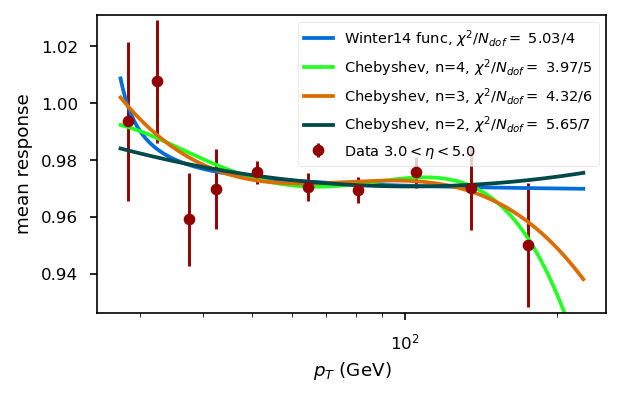

/tmp/anpotreb/ipykernel_31327/4222208775.py:3: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


Winter 14 fit failed


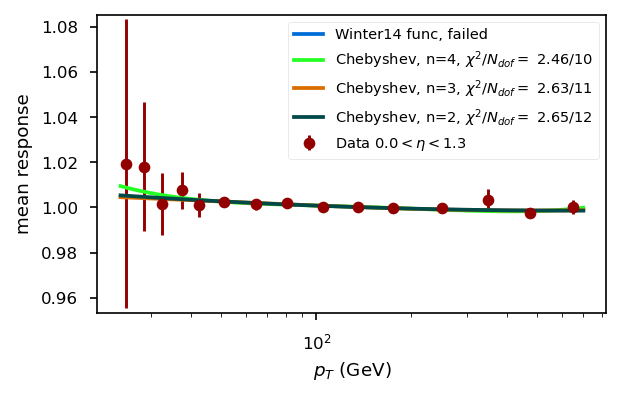

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


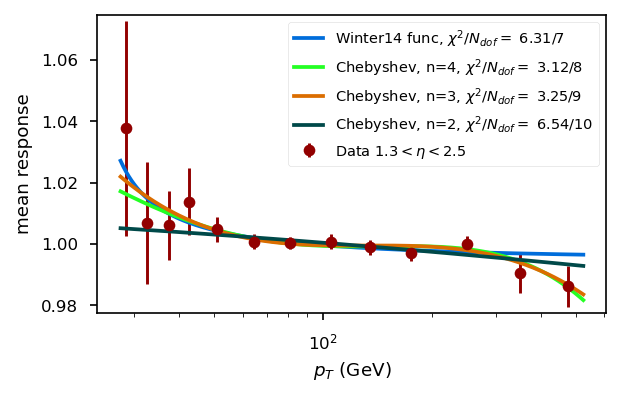

Winter 14 fit failed


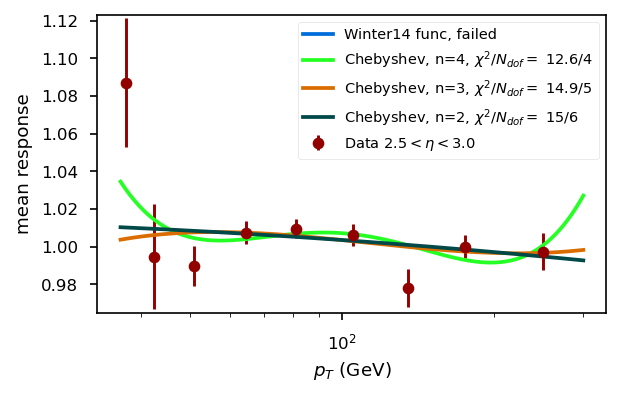

/tmp/anpotreb/ipykernel_31327/4222208775.py:3: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


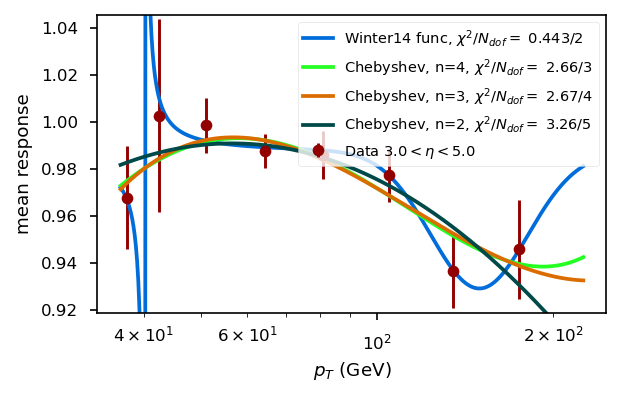

In [214]:
subsamples = ['_b', '_c', '_l', '_g']
subsamples = ['_b', '_c']


for samp in subsamples:
    for etabin in range(4):
        mean = read_data("Mean", samp)[:,etabin]
        meanvar = read_data("MeanVar", samp)[:,etabin]

        mean_range_pt = range(15,len(mean)-7)
        mean_range = mean_range_pt[:-1]

        ptbins2fit = ptbins[mean_range_pt]
        ptbins2fit = (ptbins2fit[:-1]+ptbins2fit[1:])/2
        means = mean[mean_range]

        means2fit = means[means!=0.0]
        ptbins2fit = ptbins2fit[means!=0.0]
        meanvar2fit = np.abs(meanvar[mean_range][means!=0.0])

        xvals = np.linspace(ptbins2fit.min() - (1), ptbins2fit.max()+50,1000) #-200 to plot the fitted curved outside of the points
        def sum_cheb(x, *p):
            return sum_cheb_tmp(x, ptbins2fit, *p)
        def sum_cheb5(x, *p):
            return sum_cheb5_tmp(x, ptbins2fit, *p)    
        def sum_cheb3(x, *p):
            return sum_cheb3_tmp(x, ptbins2fit, *p)  
        def sum_cheb2(x, *p):
            return sum_cheb2_tmp(x, ptbins2fit, *p)  
            
        try:
            p_resp, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=init_vals_2014[samp[-1:]][etabin]) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
            p_resp_err, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=p_resp, sigma=np.sqrt(meanvar2fit))
        except(RuntimeError):
            print("Winter 14 fit failed")
            p_resp, p_resp_err = [[np.nan]*6]*2
        #      = np.nan*6

        # p_resp_err
        p_cheb1, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1])
        p_cheb, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=p_cheb1, sigma=np.sqrt(meanvar2fit))
        p_cheb5_1, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1, 1])
        p_cheb5, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=p_cheb5_1, sigma=np.sqrt(meanvar2fit))
        p_cheb3_1, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1])
        p_cheb3, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=p_cheb3_1, sigma=np.sqrt(meanvar2fit))
        p_cheb2_1, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=[ 1, 1, 1])
        p_cheb2, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=p_cheb2_1, sigma=np.sqrt(meanvar2fit))

        yvals_resp = response_fnc(xvals, *p_resp)
        yvals_resp_err = response_fnc(xvals, *p_resp_err)
        yvals = sum_cheb(xvals, *p_cheb)
#         yvals1 = sum_cheb(xvals, *p_cheb1)
        yvalsC5 = sum_cheb5(xvals, *p_cheb5)
#         yvalsC5_1 = sum_cheb5(xvals, *p_cheb5_1)
        yvalsC3 = sum_cheb3(xvals, *p_cheb3)
        yvalsC2 = sum_cheb2(xvals, *p_cheb2)

        chi2_resp = np.sum((response_fnc(ptbins2fit, *p_resp_err) - means2fit)**2/meanvar2fit)
        chi2_C4 = np.sum((sum_cheb(ptbins2fit, *p_cheb) - means2fit)**2/meanvar2fit)
        chi2_C5 = np.sum((sum_cheb5(ptbins2fit, *p_cheb5) - means2fit)**2/np.abs(meanvar2fit))
        chi2_C3 = np.sum((sum_cheb3(ptbins2fit, *p_cheb3) - means2fit)**2/np.abs(meanvar2fit))
        chi2_C2 = np.sum((sum_cheb2(ptbins2fit, *p_cheb2) - means2fit)**2/np.abs(meanvar2fit))
        Ndof_C4 = len(ptbins2fit) - 5
        Ndof_C5 = len(ptbins2fit) - 6
        Ndof_C3 = len(ptbins2fit) - 4
        Ndof_C2 = len(ptbins2fit) - 3
        Ndof_resp = len(ptbins2fit) - 6


        fig, ax = plt.subplots()

        plt.errorbar(ptbins2fit, means2fit, yerr=np.sqrt(np.abs(meanvar2fit)), marker='o',
                     linestyle="none", label=f'Data {etabins_mod[etabin]}'+r'$<\eta<'+f'${etabins_mod[etabin+1]}')

        eta_string = '_eta'+str(etabins_mod[etabin])+'to'+str(etabins_mod[etabin+1])
        eta_string = eta_string.replace('.','')
        if np.isnan(chi2_resp): 
            winter14_lab = 'Winter14 func, failed'
        else:
            winter14_lab= 'Winter14 func, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_resp, Ndof_resp)

        ax.plot(xvals, yvals_resp_err, label=winter14_lab, linewidth=1.8);
        ax.plot(xvals, yvals, label=r'Chebyshev, n=4, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C4, Ndof_C4),linewidth=1.8);
#         ax.plot(xvals, yvalsC5, label=r'Chebyshev, n=5, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C5, Ndof_C5),linewidth=1.8);
        ax.plot(xvals, yvalsC3, label=r'Chebyshev, n=3, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C3, Ndof_C3),linewidth=1.8);
        ax.plot(xvals, yvalsC2, label=r'Chebyshev, n=2, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C2, Ndof_C2),linewidth=1.8);

    
#         yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
#         y_norm = np.concatenate([mean_p[start:,[k2, k4, k6, k8]]])
    #     print("ynorm = ", y_norm)
    #     print("yerr = ", yerr_norm)
        std = np.sqrt(np.abs(meanvar2fit))
        norm_pos = (std<0.1) &  (std != np.inf)
    #     print("(yerr_norm+y_norm)[norm_pos]) = ", (yerr_norm+y_norm)[norm_pos])
        ax.set_ylim(np.min((means2fit-std)[norm_pos])-0.002 ,np.max((std+means2fit)[norm_pos])+0.002)

        ax.set_xlabel(r'$p_T$ (GeV)');
        ax.set_ylabel(r'mean response');
        ax.set_xscale('log')
        # ax.set_ylim([0.8,1.1])
        ax.legend(prop={'size': 7})
        if not test_run:
            plt.savefig('fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
            plt.savefig('fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        else:
            plt.savefig('test/fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
            plt.savefig('test/fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        # fig.set_size_inches(6, 4, forward=True)
        plt.show();
        plt.close();
'a';

In [49]:
# mean = read_data("Mean", samp)
# meanvar = read_data("MeanVar", samp)

# means = mean[:, etabin]
# means2fit = means[means!=0.0]
# ptbins2fit = ptbins[:-1][means!=0.0]
# meanvar2fit = np.abs(meanvar[means!=0.0,etabin])

# xvals = np.linspace(ptbins2fit.min() - (0.5), ptbins2fit.max()+(ptbins2fit[-1]-ptbins2fit[-11]),1000)

In [50]:
# try:
#     p_resp, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=init_vals_2014[samp[-1]][etabin]) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
#     p_resp_err, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=p_resp, sigma=np.sqrt(meanvar2fit))
# except(RuntimeError):
#     print("Winter 14 fit failed")
#     p_resp, p_resp_err = [[np.nan]*6]*2
# #      = np.nan*6
    
# # p_resp_err
# p_cheb1, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1])
# p_cheb, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=p_cheb1, sigma=np.sqrt(meanvar2fit))
# p_cheb5_1, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1, 1])
# p_cheb5, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=p_cheb5_1, sigma=np.sqrt(meanvar2fit))


In [51]:
# yvals_resp = response_fnc(xvals, *p_resp)
# yvals_resp_err = response_fnc(xvals, *p_resp_err)
# yvals = sum_cheb(xvals, *p_cheb)
# yvals1 = sum_cheb(xvals, *p_cheb1)
# yvalsC5 = sum_cheb5(xvals, *p_cheb5)
# yvalsC5_1 = sum_cheb5(xvals, *p_cheb5_1)

In [52]:
# chi2_resp = np.sum((response_fnc(ptbins2fit, *p_resp_err) - means2fit)**2/meanvar2fit)
# chi2_C4 = np.sum((sum_cheb(ptbins2fit, *p_cheb) - means2fit)**2/meanvar2fit)
# chi2_C5 = np.sum((sum_cheb5(ptbins2fit, *p_cheb5) - means2fit)**2/np.abs(meanvar2fit))
# Ndof_C4 = len(ptbins2fit) - 5
# Ndof_C5 = len(ptbins2fit) - 6
# Ndof_resp = len(ptbins2fit) - 6


### Playground with fitting and plotting

In [83]:
def read_data(name, samp, tag_full):
#     if not test_run:
    df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
#     else: #before_closure/
#     df_csv = pd.read_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+tag+'_test.csv')
    
#     df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5.csv').set_index('etaBins')
    data = df_csv.to_numpy().transpose()
    return data

In [244]:
len(ptbins)
len(mean_QCD[:,0])

43

42

In [ ]:
# load_fit_res=True
subsamples = ['', '_b', '_c', '_l', '_g']

k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]

ks = [k2, k4] #, k6, k8]
subsamples = [''] #, '_b']
for samp in subsamples:
    for k in ks:
#     print('-'*25)
#     print('-'*25)
        print('Fitting subsample: ', samp)
        mean_QCD = read_data("Mean", samp, '_L5_QCD')
        meanvar_QCD = read_data("MeanVar", samp, '_L5_QCD')
        mean_TTBAR = read_data("Mean", samp, '_L5_TTBAR')
        meanvar_TTBAR = read_data("MeanVar", samp, '_L5_TTBAR')

        mean_p_QCD = mean_QCD.copy()
        mean_p_QCD[mean_p_QCD==0] = np.nan

        mean_p_TTBAR = mean_TTBAR.copy()
        mean_p_TTBAR[mean_p_TTBAR==0] = np.nan

        gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, height_ratios=[3, 1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
#         fig, [ax,ax2] = plt.subplots(nrows=2, ncols=1, gridspec_kw=gs)
        start = 17



        p1 = plt.errorbar(ptbins[start:-1],mean_p_QCD[start:,k], yerr=np.sqrt(meanvar_QCD[start:,k]), marker='o',
                     markerfacecolor='none', markeredgewidth=1,
                     linestyle="none", label=f'${etabins_mod[k]}<\eta<{etabins_mod[k+1]}$')
        # p2 = plt.errorbar(ptbins[start:-1],mean_p_QCD[start:,k4], yerr=np.sqrt(meanvar_QCD[start:,k4]), marker='o',
        #              markerfacecolor='none', markeredgewidth=1,
        #          linestyle="none", label=f'${etabins_mod[k4]}<\eta<{etabins_mod[k4+1]}$')
        # p3 = plt.errorbar(ptbins[start:-1],mean_p_QCD[start:,k6], yerr=np.sqrt(meanvar_QCD[start:,k6]), marker='o',
        #              markerfacecolor='none', markeredgewidth=1,
        #          linestyle="none", label=f'${etabins_mod[k6]}<\eta<{etabins_mod[k6+1]}$')
        # p4 = plt.errorbar(ptbins[start:-1],mean_p_QCD[start:,k8], yerr=np.sqrt(meanvar_QCD[start:,k8]), marker='o',
        #              markerfacecolor='none', markeredgewidth=1,
        #          linestyle="none", label=f'${etabins_mod[k8]}<\eta<{etabins_mod[k8+1]}$')

        p5 = plt.errorbar(ptbins[start:-1],mean_p_TTBAR[start:,k], yerr=np.sqrt(meanvar_TTBAR[start:,k]), marker='v',
                     markerfacecolor='none', markeredgewidth=1, color=p1.lines[0].get_color(),
                     linestyle="none")
        # plt.errorbar(ptbins[start:-1],mean_p_TTBAR[start:,k4], yerr=np.sqrt(meanvar_TTBAR[start:,k4]), marker='v',
        #              markerfacecolor='none', markeredgewidth=1, color=p2.lines[0].get_color(),
        #          linestyle="none")
        # plt.errorbar(ptbins[start:-1],mean_p_TTBAR[start:,k6], yerr=np.sqrt(meanvar_TTBAR[start:,k6]), marker='v',
        #              markerfacecolor='none', markeredgewidth=1, color=p3.lines[0].get_color(),
        #          linestyle="none")
        # plt.errorbar(ptbins[start:-1],mean_p_TTBAR[start:,k8], yerr=np.sqrt(meanvar_TTBAR[start:,k8]), marker='v',
        #              markerfacecolor='none', markeredgewidth=1, color=p4.lines[0].get_color(),
        #          linestyle="none")


#         p1 = ax.plot(ptbins[start:-1],mean_p_QCD[start:,k2], marker='o',
#                       markerfacecolor='none', markeredgewidth=1,
#                      linestyle="none", label=f'${etabins_mod[k2]}<\eta<{etabins_mod[k2+1]}$')
    #     p2 = ax.plot(ptbins[start:-1],mean_p_QCD[start:,k4], marker='o', 
    #                  markerfacecolor='none', markeredgewidth=1,
    #              linestyle="none", label=f'${etabins_mod[k4]}<\eta<{etabins_mod[k4+1]}$')
    #     p3 = ax.plot(ptbins[start:-1],mean_p_QCD[start:,k6], marker='o', 
    #                  markerfacecolor='none', markeredgewidth=1,
    #              linestyle="none", label=f'${etabins_mod[k6]}<\eta<{etabins_mod[k6+1]}$')
    #     p4 = ax.plot(ptbins[start:-1],mean_p_QCD[start:,k8], marker='o', 
    #                  markerfacecolor='none', markeredgewidth=1,
    #              linestyle="none", label=f'${etabins_mod[k8]}<\eta<{etabins_mod[k8+1]}$')

#         p5 = ax.plot(ptbins[start:-1],mean_p_TTBAR[start:,k2], marker='v', 
#                      markerfacecolor='none', markeredgewidth=1, color=p1[0].get_color(),
#                      linestyle="none")
    #     ax.plot(ptbins[start:-1],mean_p_TTBAR[start:,k4], marker='v', 
    #                  markerfacecolor='none', markeredgewidth=1, color=p2[0].get_color(),
    #              linestyle="none")
    #     ax.plot(ptbins[start:-1],mean_p_TTBAR[start:,k6], marker='v', 
    #                  markerfacecolor='none', markeredgewidth=1, color=p3[0].get_color(),
    #              linestyle="none")
    #     ax.plot(ptbins[start:-1],mean_p_TTBAR[start:,k8], marker='v', 
    #                  markerfacecolor='none', markeredgewidth=1, color=p4[0].get_color(),
    #              linestyle="none")

        ax3 = ax.twinx()
        ax3.plot(np.nan, marker='o',color='k',markerfacecolor='none', markeredgewidth=1, linestyle="none", label='QCD')
        ax3.plot(np.nan, marker='v',color='k',markerfacecolor='none', markeredgewidth=1, linestyle="none", label='TTBAR')

        ### Calculate resonable limits excluding the few points with insane errors
        yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
        y_norm = np.concatenate([mean_p_TTBAR[start:,[k2, k4, k6, k8]]])
        norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
        ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))


        ax.set_xlabel(r'$p_T$ (GeV)');
        ax.set_ylabel(r'mean response');
        ax.set_xscale('log')
        ax.set_xticks([20, 50,100, 500, 1000, 5000])
#         ax.get_xaxis().get_major_formatter().labelOnlyBase = False
        ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        leg1 = ax.legend()
        leg1 = ax3.legend(loc='upper left')
        # fig.legend((p1, p5), ('QCD', 'TTBAR'), loc='upper right')  #,bbox_to_anchor=(0.5, 0., 0.47, 0.98)) #loc="upper right")
        # if test_run:
        #     plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        #     plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
        # else:
        eta_string = '_eta'+str(etabins_mod[k])+'to'+str(etabins_mod[k+1])
        eta_string = eta_string.replace('.','')
        
        plt.savefig('fig/corr_vs_pt'+samp+eta_string+'_L5_QCD_TTBAR.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+eta_string+'_L5_QCD_TTBAR.png');
        # gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])
        plt.show();
3;

### QCD vs TTbar comparisson

Fitting subsample:  


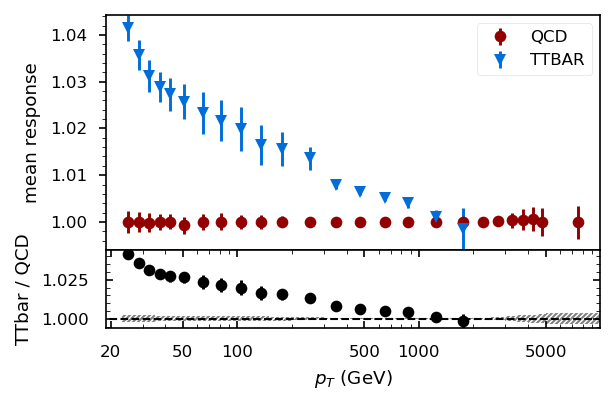

Fitting subsample:  


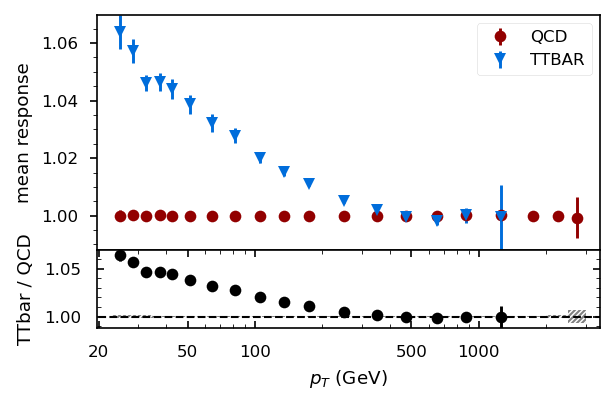

Fitting subsample:  


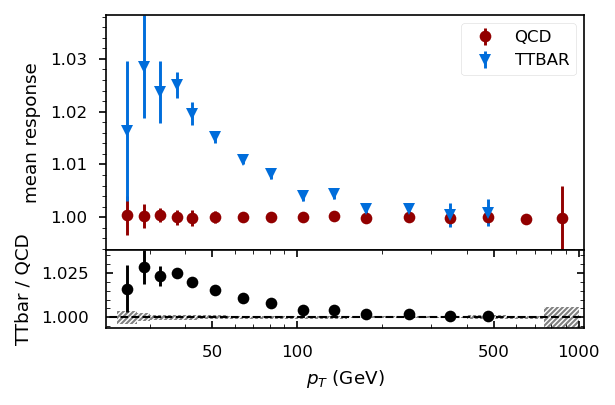

Fitting subsample:  


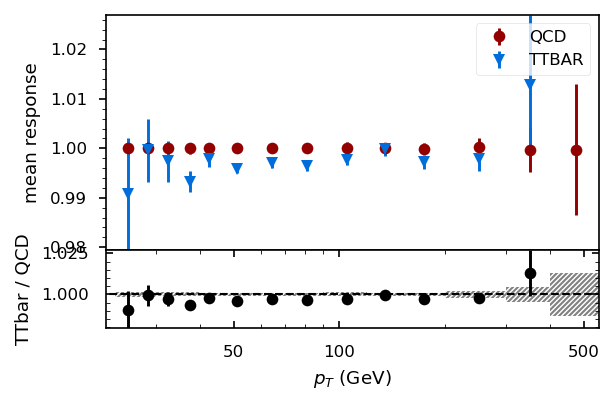

Fitting subsample:  _b


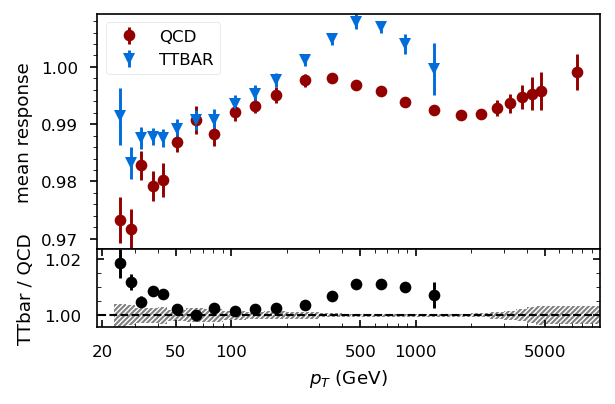

Fitting subsample:  _b


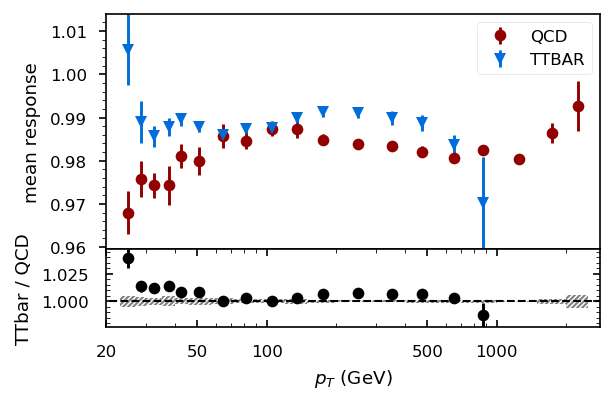

Fitting subsample:  _b


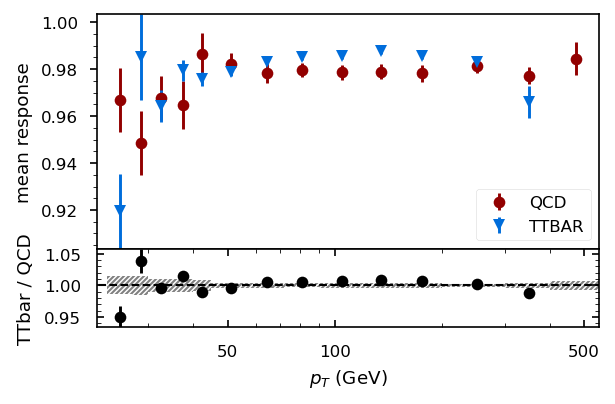

Fitting subsample:  _b


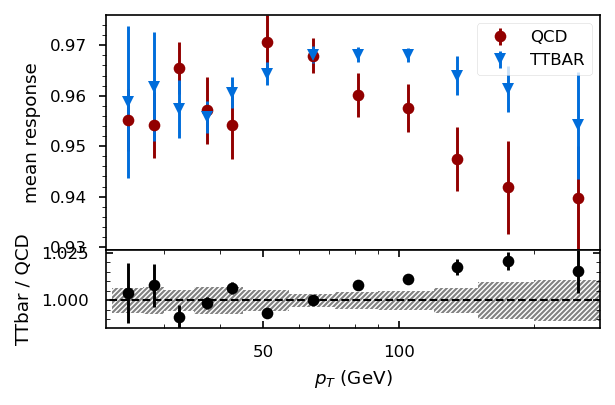

Fitting subsample:  _c


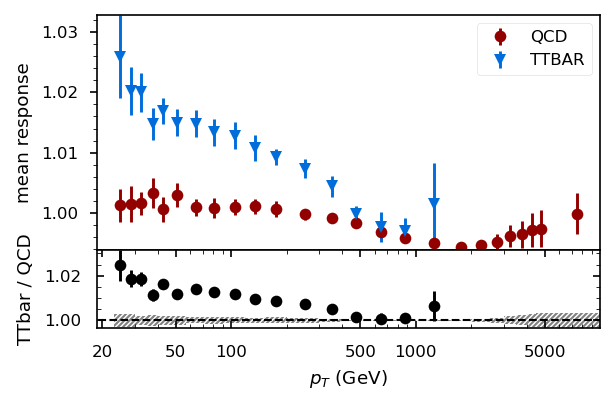

Fitting subsample:  _c


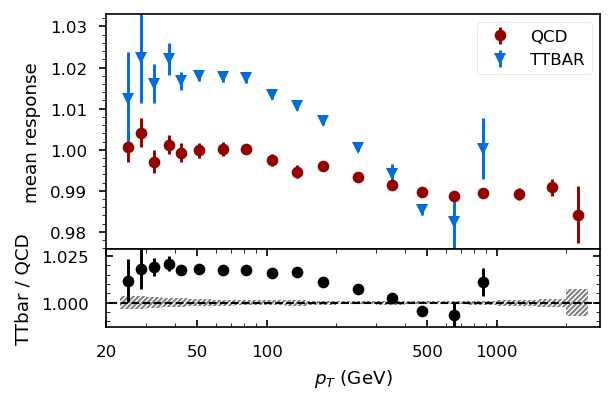

Fitting subsample:  _c


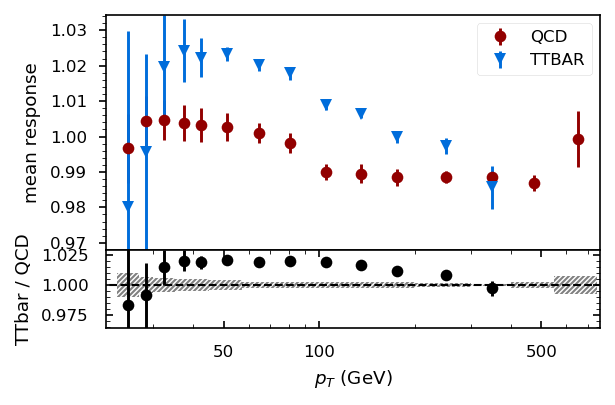

Fitting subsample:  _c


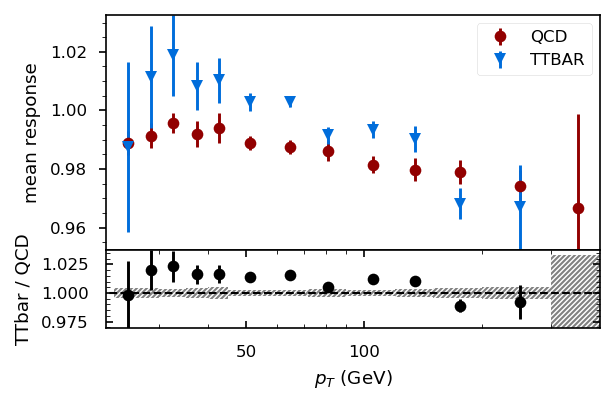

Fitting subsample:  _l


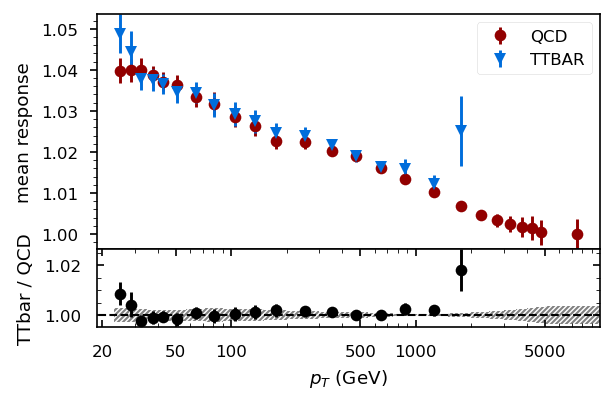

Fitting subsample:  _l


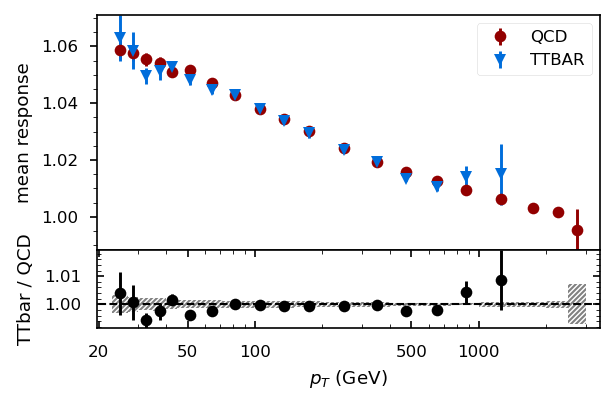

Fitting subsample:  _l


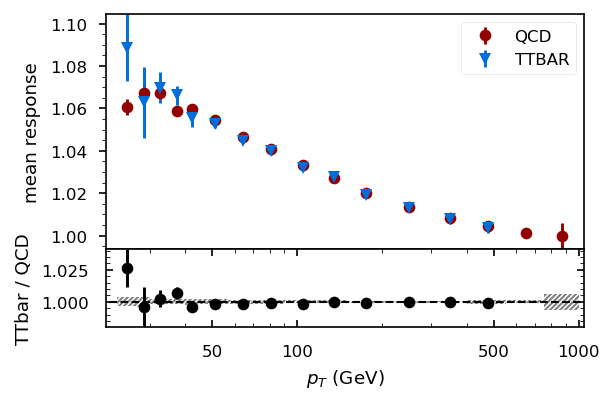

Fitting subsample:  _l


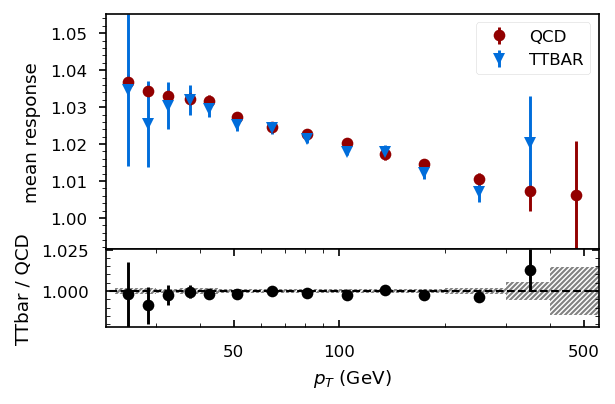

Fitting subsample:  _g


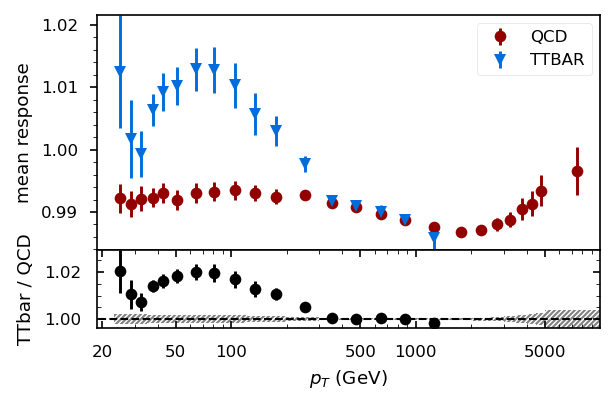

Fitting subsample:  _g


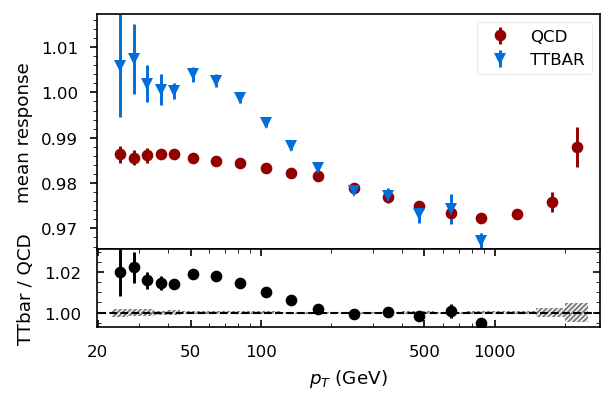

Fitting subsample:  _g


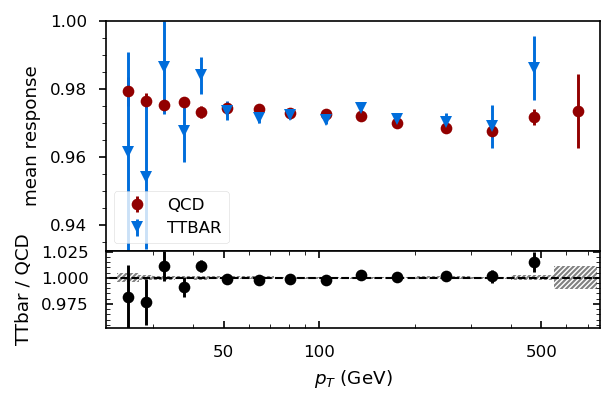

Fitting subsample:  _g


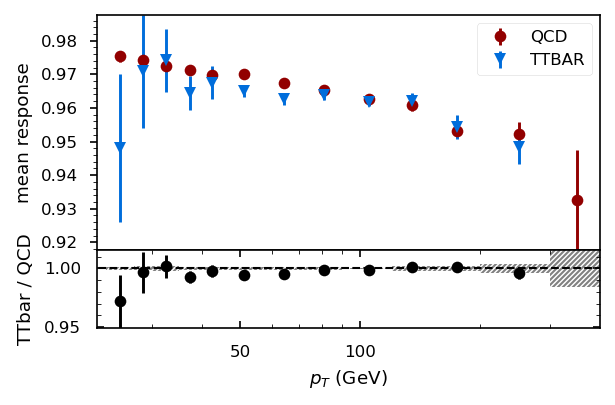

In [86]:
# load_fit_res=True
subsamples = ['', '_b', '_c', '_l', '_g']

k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]

# ks = [k2, k4] #, k6, k8]
# subsamples = ['_b'] #, '_b']
for samp in subsamples:
    for k in ks:
#     print('-'*25)
#     print('-'*25)
        print('Fitting subsample: ', samp)
        mean_QCD = read_data("Mean", samp, '_L5_QCD')
        meanvar_QCD = read_data("MeanVar", samp, '_L5_QCD')
        mean_TTBAR = read_data("Mean", samp, '_L5_TTBAR')
        meanvar_TTBAR = read_data("MeanVar", samp, '_L5_TTBAR')
        
        
        mean_p_QCD = mean_QCD.copy()
        mean_p_QCD[mean_p_QCD==0] = np.nan

        mean_p_TTBAR = mean_TTBAR.copy()
        mean_p_TTBAR[mean_p_TTBAR==0] = np.nan

        fig = plt.figure()
        gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, height_ratios=[3, 1])
        ax = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
#         fig, [ax,ax2] = plt.subplots(nrows=2, ncols=1)
        start = 17
    
#         for item in (
#             [ax1.yaxis.label, ax2.xaxis.label, ax2.yaxis.label]
#             + ax1.get_yticklabels()
#             + ax2.get_xticklabels()
#             + ax2.get_yticklabels()
#         ):
#             item.set_fontsize("large")
    
        for axis in [ax.xaxis, ax.yaxis, ax2.xaxis, ax2.yaxis]:
            axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

        xvals = (ptbins[start:-1] + ptbins[start+1:])/2
        wd = np.abs(ptbins[start:-1] - ptbins[start+1:])
        QCD_vals = mean_p_QCD[start:,k]
        TTbar_vals = mean_p_TTBAR[start:,k]

        p1 = ax.errorbar(xvals, QCD_vals, yerr=np.sqrt(meanvar_QCD[start:,k]), marker='o',
#                      markerfacecolor='none', markeredgewidth=1,
                     linestyle="none", label='QCD')

        p5 = ax.errorbar(xvals, TTbar_vals, yerr=np.sqrt(meanvar_TTBAR[start:,k]), marker='v',
#                      markerfacecolor='none', markeredgewidth=1, color=p1.lines[0].get_color(),
                     linestyle="none", label='TTBAR')
        
        ax2.hlines(1,1, 10000, linestyles='--',color="black",
            linewidth=1,)
        # ratio plot
#         ax2.plot(
#             [ptbins[0], ptbins[-1]],
#             [1, 1],
#             "--",
#             color="black",
#             linewidth=1,
#         )  # reference line along y=1
        
#         nonzero_model_yield = mean_p_QCD[start:,k] != 0.0
        rel_mc_unc =  np.sqrt(meanvar_QCD[start:,k])/QCD_vals 
        
        ax2.bar(
            xvals,
            2 * rel_mc_unc,
            width=wd,
            bottom=1.0 - rel_mc_unc,
            fill=False,
            linewidth=0,
            edgecolor="gray",
            hatch=10 * "/",
        )
        
        
#         ax3 = ax.twinx()
#         ax3.plot(np.nan, marker='o',color='k',markerfacecolor='none', markeredgewidth=1, linestyle="none", label='QCD')
#         ax3.plot(np.nan, marker='v',color='k',markerfacecolor='none', markeredgewidth=1, linestyle="none", label='TTBAR')

        # data in ratio plot
        data_model_ratio = TTbar_vals/QCD_vals
        data_model_ratio_unc = np.sqrt(meanvar_TTBAR[start:,k]) / QCD_vals
        # mask data in bins where total model yield is 0
        ax2.errorbar(
            xvals,
            data_model_ratio, #[nonzero_model_yield],
            yerr=data_model_ratio_unc, #[nonzero_model_yield],
            fmt="o",
            color="k",
        )
        
#             # figure label (region name)
#         label = 'Blaaaaah'
#         at = mpl.offsetbox.AnchoredText(
#             label,
#             loc="upper left",
#             frameon=False,
#             prop={"fontsize": "large", "linespacing": 1.5},
#         )
#         ax.add_artist(at)
        
#         ax.set_xlim(ptbins[start],ptbins[-1])

        
        ax2.set_ylabel("TTbar / QCD")
        ax2.tick_params(axis="both", which="major", pad=8)
        ax2.tick_params(direction="in", top=True, right=True, which="both")

        fig.set_tight_layout(True)

        ### Calculate resonable limits excluding the few points with insane errors
        yerr_norm = np.concatenate([np.sqrt(meanvar_QCD[start:,k]), np.sqrt(meanvar_TTBAR[start:,k]) ])
        y_norm = np.concatenate([QCD_vals, TTbar_vals])
        norm_pos = (yerr_norm<0.03) &  (yerr_norm != np.inf) & (y_norm>-0.1)
        ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))
        
        yerr_norm = np.concatenate([np.sqrt(meanvar_QCD[start:,k])/QCD_vals, np.sqrt(meanvar_TTBAR[start:,k])/QCD_vals ])
        y_norm = np.concatenate([QCD_vals/QCD_vals, TTbar_vals/QCD_vals])
        norm_pos = (yerr_norm<0.03) &  (yerr_norm != np.inf) & (y_norm>-0.1) 
        ax2.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))

        ax2.set_xlabel(r'$p_T$ (GeV)');
#         ax.set_xlabel(r'$p_T$ (GeV)');
        ax.set_ylabel(r'mean response');
        ax.set_xscale('log')
        ax2.set_xscale('log')
        
        ax.set_xticks([])
        ax2.set_xticks([20, 50,100, 500, 1000, 5000])
#         ax.get_xaxis().get_major_formatter().labelOnlyBase = False
        ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        leg1 = ax.legend()
#         leg1 = ax3.legend(loc='upper left')
        # fig.legend((p1, p5), ('QCD', 'TTBAR'), loc='upper right')  #,bbox_to_anchor=(0.5, 0., 0.47, 0.98)) #loc="upper right")
        # if test_run:
        #     plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        #     plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
        # else:
#         print("x lim = ", ax.get_xlim())
        ax2.set_xlim(ax.get_xlim())
        eta_string = '_eta'+str(etabins_mod[k])+'to'+str(etabins_mod[k+1])
        eta_string = eta_string.replace('.','')
        
        plt.savefig('fig/corr_vs_pt'+samp+eta_string+'_L5_QCD_TTBAR.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+eta_string+'_L5_QCD_TTBAR.png');
        # gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])
        plt.show();
3;

### Herwig vs Pythia comparisson

Fitting subsample:  


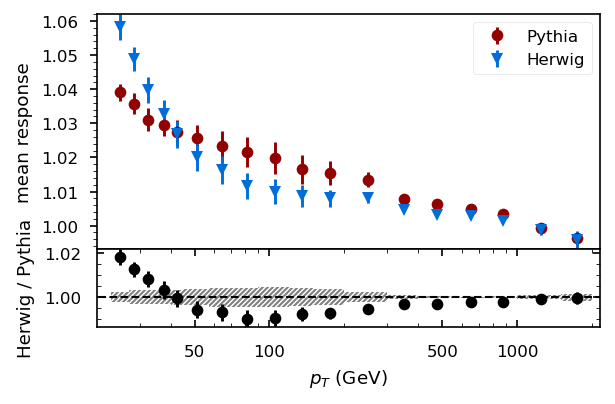

Fitting subsample:  


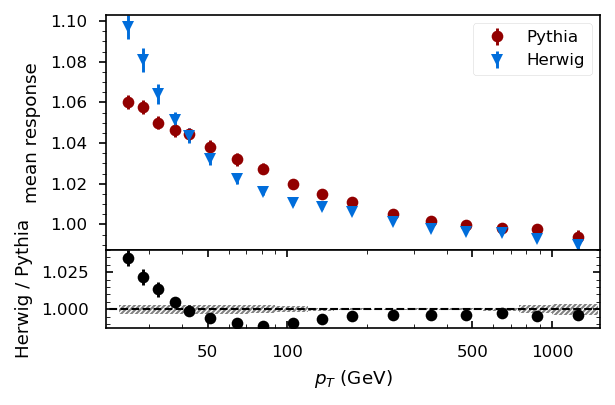

Fitting subsample:  


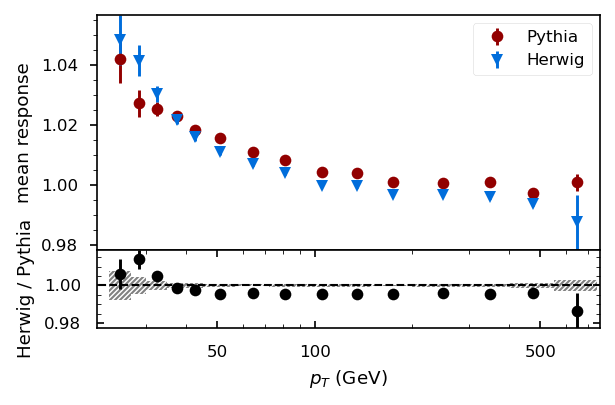

Fitting subsample:  


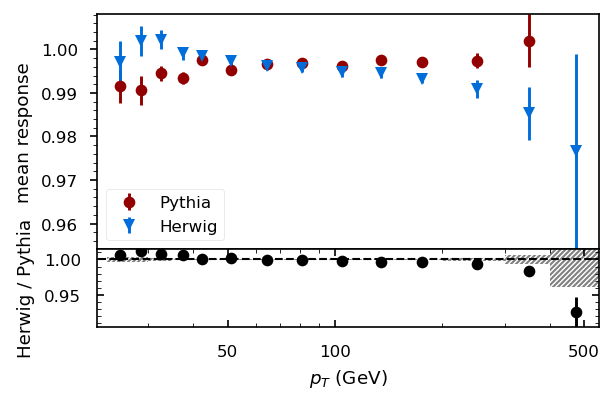

Fitting subsample:  _b


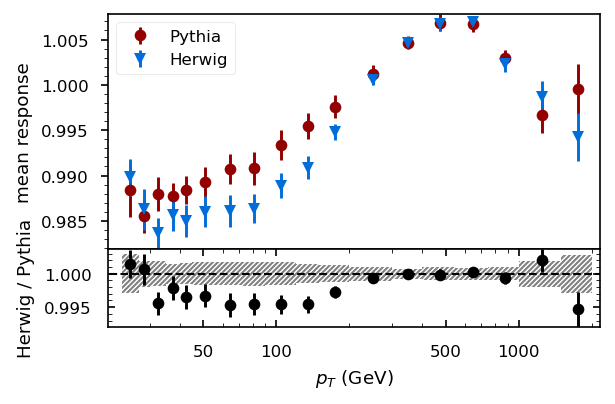

Fitting subsample:  _b


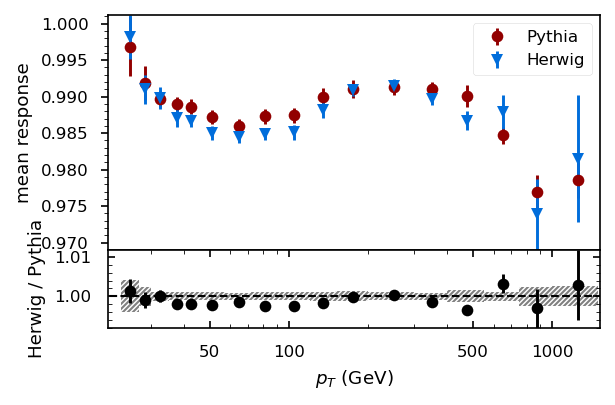

Fitting subsample:  _b


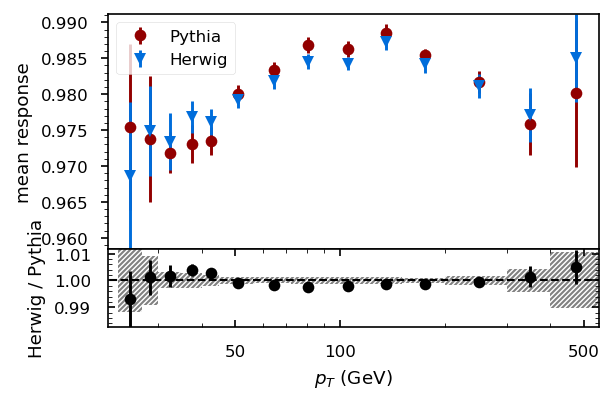

Fitting subsample:  _b


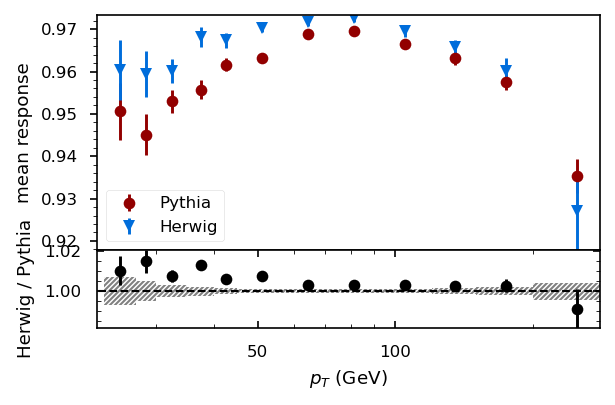

Fitting subsample:  _c


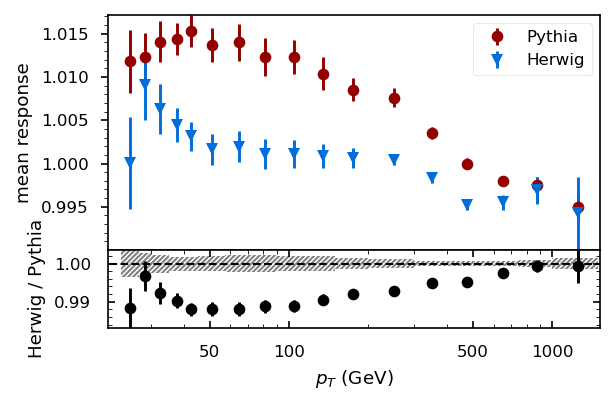

Fitting subsample:  _c


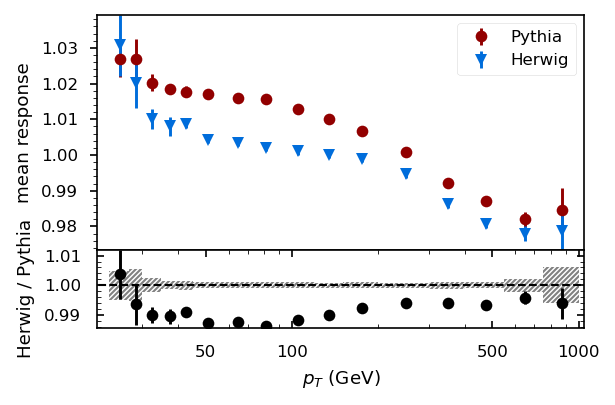

Fitting subsample:  _c


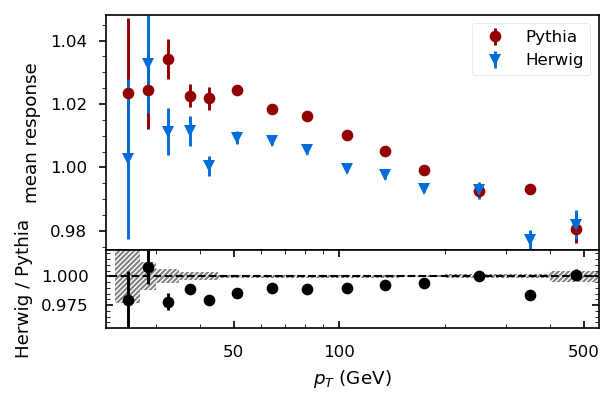

Fitting subsample:  _c


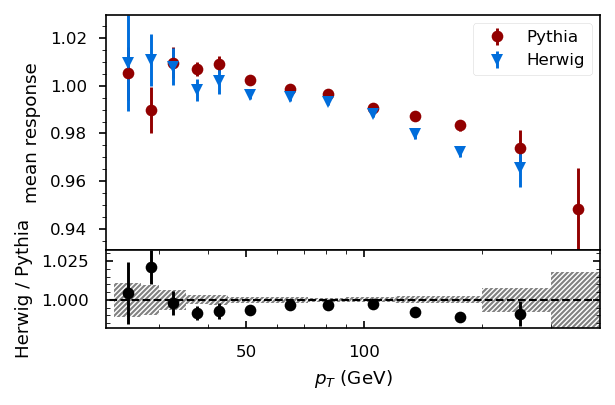

In [87]:
# load_fit_res=True
subsamples = ['', '_b', '_c']

k2 = np.where(etabins_mod<=0)[0][-1]
k4 = np.where(etabins_mod<=1.3)[0][-1]
k6 = np.where(etabins_mod<=2.5)[0][-1]
k8 = np.where(etabins_mod<=3.0)[0][-1]
ks = [k2, k4, k6, k8]

ks = [k2, k4, k6, k8] #, k6, k8]
# subsamples = ['_b'] #, '_b']
for samp in subsamples:
    for k in ks:
        print('Fitting subsample: ', samp)
        mean_TTBAR = read_data("Mean", samp, '_L5_TTBAR-hadflav-0-50')
        meanvar_TTBAR = read_data("MeanVar", samp, '_L5_TTBAR-hadflav-0-50')
        mean_Herwig = read_data("Mean", samp, '_L5_Herwig-TTBAR')
        meanvar_Herwig = read_data("MeanVar", samp, '_L5_Herwig-TTBAR')

        mean_p_Herwig = mean_Herwig.copy()
        mean_p_Herwig[mean_p_Herwig==0] = np.nan

        mean_p_TTBAR = mean_TTBAR.copy()
        mean_p_TTBAR[mean_p_TTBAR==0] = np.nan

        fig = plt.figure()
        gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, height_ratios=[3, 1])
        ax = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
#         fig, [ax,ax2] = plt.subplots(nrows=2, ncols=1)
        start = 17
    

        for axis in [ax.xaxis, ax.yaxis, ax2.xaxis, ax2.yaxis]:
            axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

        xvals = (ptbins[start:-1] + ptbins[start+1:])/2
        wd = np.abs(ptbins[start:-1] - ptbins[start+1:])
        Herwig_vals = mean_p_Herwig[start:,k]
        TTbar_vals = mean_p_TTBAR[start:,k]

        p5 = ax.errorbar(xvals, TTbar_vals, yerr=np.sqrt(meanvar_TTBAR[start:,k]), marker='o',
#                      markerfacecolor='none', markeredgewidth=1, color=p1.lines[0].get_color(),
                     linestyle="none", label='Pythia')
      
        p1 = ax.errorbar(xvals, Herwig_vals, yerr=np.sqrt(meanvar_Herwig[start:,k]), marker='v',
#                      markerfacecolor='none', markeredgewidth=1,
                     linestyle="none", label='Herwig')

   
        ax2.hlines(1,1, 10000, linestyles='--',color="black",
            linewidth=1,)
        rel_mc_unc =  np.sqrt(meanvar_TTBAR[start:,k])/TTbar_vals 
        
        ax2.bar(
            xvals,
            2 * rel_mc_unc,
            width=wd,
            bottom=1.0 - rel_mc_unc,
            fill=False,
            linewidth=0,
            edgecolor="gray",
            hatch=10 * "/",
        )
        
        data_model_ratio = Herwig_vals/TTbar_vals
        data_model_ratio_unc = np.sqrt(meanvar_Herwig[start:,k]) / TTbar_vals
        # mask data in bins where total model yield is 0
        ax2.errorbar(
            xvals,
            data_model_ratio, #[nonzero_model_yield],
            yerr=data_model_ratio_unc, #[nonzero_model_yield],
            fmt="o",
            color="k",
        )
        
        
        ax2.set_ylabel("Herwig / Pythia")
        ax2.tick_params(axis="both", which="major", pad=8)
        ax2.tick_params(direction="in", top=True, right=True, which="both")

        fig.set_tight_layout(True)

        ### Calculate resonable limits excluding the few points with insane errors
        yerr_norm = np.concatenate([np.sqrt(meanvar_Herwig[start:,k]), np.sqrt(meanvar_TTBAR[start:,k]) ])
        y_norm = np.concatenate([Herwig_vals, TTbar_vals])
        norm_pos = (yerr_norm<0.03) &  (yerr_norm != np.inf) & (y_norm>-0.1)
        ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))
        
        yerr_norm = np.concatenate([np.sqrt(meanvar_Herwig[start:,k])/TTbar_vals, np.sqrt(meanvar_TTBAR[start:,k])/TTbar_vals ])
        y_norm = np.concatenate([Herwig_vals/TTbar_vals, TTbar_vals/TTbar_vals])
        norm_pos = (yerr_norm<0.03) &  (yerr_norm != np.inf) & (y_norm>-0.1) 
        ax2.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]), np.max((yerr_norm+y_norm)[norm_pos]))

        ax2.set_xlabel(r'$p_T$ (GeV)');
#         ax.set_xlabel(r'$p_T$ (GeV)');
        ax.set_ylabel(r'mean response');
        ax.set_xscale('log')
        ax2.set_xscale('log')
        
        ax.set_xticks([])
        ax2.set_xticks([20, 50,100, 500, 1000, 5000])
#         ax.get_xaxis().get_major_formatter().labelOnlyBase = False
        ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        leg1 = ax.legend()
#         leg1 = ax3.legend(loc='upper left')

        ax2.set_xlim(ax.get_xlim())
        eta_string = '_eta'+str(etabins_mod[k])+'to'+str(etabins_mod[k+1])
        eta_string = eta_string.replace('.','')
        
        plt.savefig('fig/corr_vs_pt'+samp+eta_string+'_L5_Herwig_Pythia-hadflav.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+eta_string+'_L5_Herwig_Pythia-hadflav.png');
        # gs1.tight_layout(fig, rect=[0, 0.1, 0.8, 0.5])
        plt.show();
3;

In [280]:
yerr_norm = np.concatenate([np.sqrt(meanvar_QCD[start:,k]), np.sqrt(meanvar_TTBAR[start:,k]) ])
y_norm = np.concatenate([QCD_vals, TTbar_vals])
norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)

In [ ]:
def plot_corrections(mean, samp, meanvar):
    ### To ignore the points with 0 on y axis when setting the y axis limits
    mean_p = mean.copy()
    mean_p[mean_p==0] = np.nan

    # h = np.max(histo.values()[('QCD',)])
    fig, ax = plt.subplots()
    start = 17
    
#     etabins_mod = np.flip(etabins[(len(etabins)-1)//2:])
    
#     k1 = np.where(etabins<=-1.3)[0][-1]
    k2 = np.where(etabins_mod<=0)[0][-1]
#     k3 = np.where(etabins<=-2.5)[0][-1]
    k4 = np.where(etabins_mod<=1.3)[0][-1]
#     k5 = np.where(etabins<=-3)[0][-1]
    k6 = np.where(etabins_mod<=2.5)[0][-1]
#     k7 = np.where(etabins<=-5)[0][-1]
    k8 = np.where(etabins_mod<=3.0)[0][-1]
    

    plt.errorbar(ptbins[start:-1],mean_p[start:,k2], yerr=np.sqrt(meanvar[start:,k2]), marker='o',
                 linestyle="none", label=f'${etabins_mod[k2]}<\eta<{etabins_mod[k2+1]}$')
    plt.errorbar(ptbins[start:-1],mean_p[start:,k4], yerr=np.sqrt(meanvar[start:,k4]), marker='o',
             linestyle="none", label=f'${etabins_mod[k4]}<\eta<{etabins_mod[k4+1]}$')
    plt.errorbar(ptbins[start:-1],mean_p[start:,k6], yerr=np.sqrt(meanvar[start:,k6]), marker='o',
             linestyle="none", label=f'${etabins_mod[k6]}<\eta<{etabins_mod[k6+1]}$')
    plt.errorbar(ptbins[start:-1],mean_p[start:,k8], yerr=np.sqrt(meanvar[start:,k8]), marker='o',
             linestyle="none", label=f'${etabins_mod[k8]}<\eta<{etabins_mod[k8+1]}$')

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
    y_norm = np.concatenate([mean_p[start:,[k2, k4, k6, k8]]])
    norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))

    ax.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(r'mean response');
    ax.set_xscale('log')
    # ax.set_ylim([0.8,1.1])
    ax.legend()
    if test_run:
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
    else:
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.png');

    plt.show();
    
# plotCorrections()

In [31]:
add_tag = '_QCD' # '_testing_19UL18' # ''
tag_full = tag+add_tag

outname_QCD = 'out/CoffeaJERCOutputs_L5_QCD.coffea'
outname_TTBAR = 'out/CoffeaJERCOutputs_L5_TTBAR.coffea'


df_csv = pd.read_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+tag+'_test.csv')
    
#     df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5.csv').set_index('etaBins')
data = df_csv.to_numpy().transpose()
    
output_QCD = util.load(outname_QCD)
output_TTBAR = util.load(outname_TTBAR)


### Fit a specific $\eta$ $p_T$ bin

In [88]:

mean = np.zeros((jetpt_length, jeteta_length))
median = np.zeros((jetpt_length, jeteta_length))
width = np.zeros((jetpt_length, jeteta_length))
chi2s = np.zeros((jetpt_length, jeteta_length))
meanvar = np.zeros((jetpt_length, jeteta_length))
#     idx = []

N_converge = 0
N_not_converge = 0

FitFigDir = 'fig/response_pt_eta'+samp+tag_full
print("Images will be saved under ", FitFigDir)
if not os.path.exists(FitFigDir):
    os.mkdir(FitFigDir)
    
edd = output['ptresponse'+samp].axis('ptresponse').edges()
plot_pt_edges = edd[0:np.nonzero(edd>=2.0)[0][0]]
# plot_pt_edges = output['ptresponse'+samp].axis('ptresponse').edges()[0:42] ##Put plotting limits to the histogram
hist_pt_edges = plot_pt_edges[1:-1]   #for plotting. To explude overflow from the plot
plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

xvals = output['ptresponse'+samp].axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
f_xvals = np.linspace(0,5,5001)

Images will be saved under  fig/response_pt_eta_c_L5_Herwig_TTBAR


In [89]:
# np.where(xvals>=p[1]+np.abs(p[2])*1.5)

In [90]:
samp=''

In [163]:
hist_mean = np.sum(xvals*yvals)/sum(yvals) 
hist_std = np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals)

hist_mean
hist_std

0.9909201954397393

0.007744816921134442

In [91]:
# histo = output['ptresponse'].integrate('jeteta', hist.Interval(-2.5, -1.3)).integrate('pt', hist.Interval(300, 350))
histoMi = output['ptresponse'+samp].integrate('jeteta', hist.Interval(-3.0, -2.5)).integrate('pt', hist.Interval(300, 350))
histoPl = output['ptresponse'+samp].integrate('jeteta', hist.Interval(2.5, 3.0)).integrate('pt', hist.Interval(300, 350))
histo = (histoMi+histoPl)
histvals = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))
yvals = histo.values()[('QCD',)][1:]  #[1:] to exclude the second peak for low pt

N = histo.integrate('ptresponse').values()[('QCD',)]
nonzero_bins = np.sum(yvals>0)
if nonzero_bins<2:
    p2=[0,0,0]
    chi2 = np.nan
    arr = np.array([[np.nan]*3]*3)
    Ndof = 0
else:
    try:
        p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
        N_converge += 1

                    ### Second Gaussian
        xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
        xfit_h = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0][0]
        if len(range(xfit_l,xfit_h))<5: #if there are only 3pnts, the uncertainty is infty
        #     print(len(range(xfit_l,xfit_h)))
            xfit_l = xfit_l-1
            xfit_h = xfit_h+1
            if len(range(xfit_l,xfit_h))<5:
        #         print(len(range(xfit_l,xfit_h)))
                xfit_l = xfit_l-1
                xfit_h = xfit_h+1
        xvals2 = xvals[xfit_l: xfit_h]
        yvals2 = yvals[xfit_l: xfit_h]
        p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)

        ygaus = gauss(xvals, *p2)
        chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
        Ndof = len(xvals2)-3
    except(RuntimeError):
        "blah"
    
if chi2<50000:
    pass
    print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
else:
    print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
#             print("Fit failed because of non-convergance, p = ", p)


# fgaus = gauss(f_xvals, *p)
fgaus2 = gauss(f_xvals, *p2)

# histo.values()[('QCD',)][:-1]
# N = histo.integrate('ptresponse').values()[('QCD',)]
histo = histo.rebin('ptresponse', plot_response_axis)


Fit failed because of high chi2, p =  [40.68383869  0.99324486 -0.07524521] , chi2 =  66386956.36549482


/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:665: RuntimeWarning: Reducing along axis <Bin (name=pt) instance at 0x7f2339ac0fa0>: requested stop 350.0 between bin boundaries, no interpolation is performed
  warnings.warn(


<>:12: DeprecationWarning: invalid escape sequence \p
<>:13: DeprecationWarning: invalid escape sequence \p
<>:15: DeprecationWarning: invalid escape sequence \c
<>:12: DeprecationWarning: invalid escape sequence \p
<>:13: DeprecationWarning: invalid escape sequence \p
<>:15: DeprecationWarning: invalid escape sequence \c
/tmp/anpotreb/ipykernel_31327/4252542545.py:12: DeprecationWarning: invalid escape sequence \p
  plt.text(0.03,0.95*h,'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1],np.sqrt(arr[1,1])))
/tmp/anpotreb/ipykernel_31327/4252542545.py:13: DeprecationWarning: invalid escape sequence \p
  plt.text(0.03,0.88*h,'Width {0:0.3f}$\pm${1:0.3f}'.format(p2[2],np.sqrt(arr[2,2])))
/tmp/anpotreb/ipykernel_31327/4252542545.py:15: DeprecationWarning: invalid escape sequence \c
  plt.text(0.03,0.73*h,'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))


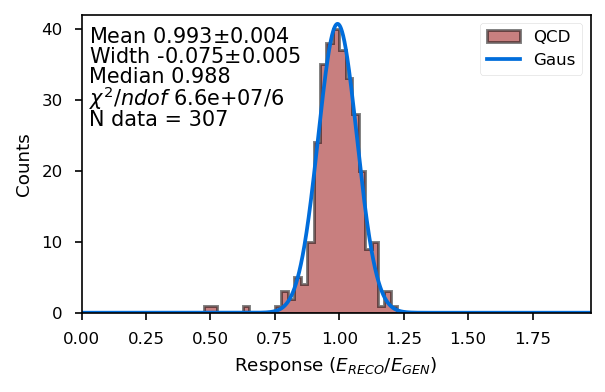

In [92]:


# h = np.max(histo.values()[('QCD',)][:-1]);
# h = h if h!=0 else 0.05
fig, ax2 = plt.subplots();
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
# ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
ax2.set_xlim(plot_pt_edges[[0,-1]])
h = ax2.get_ylim()[1]/1.05
# ax2.set_ylim(0,h)
plt.text(0.03,0.95*h,'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1],np.sqrt(arr[1,1])))
plt.text(0.03,0.88*h,'Width {0:0.3f}$\pm${1:0.3f}'.format(p2[2],np.sqrt(arr[2,2])))
plt.text(0.03,0.81*h,'Median {0:0.3f}'.format(np.median(histvals)))
plt.text(0.03,0.73*h,'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
plt.text(0.03,0.66*h,'N data = {0:0.3g}'.format(N))
ax2.legend();


In [58]:
xvals2

array([0.8875, 0.9125, 0.9375, 0.9625, 0.9875, 1.0125, 1.0375, 1.0625,
       1.0875, 1.1125])

<>:13: DeprecationWarning: invalid escape sequence \p
<>:14: DeprecationWarning: invalid escape sequence \p
<>:16: DeprecationWarning: invalid escape sequence \c
<>:13: DeprecationWarning: invalid escape sequence \p
<>:14: DeprecationWarning: invalid escape sequence \p
<>:16: DeprecationWarning: invalid escape sequence \c
/tmp/anpotreb/ipykernel_16055/3758398721.py:13: DeprecationWarning: invalid escape sequence \p
  plt.text(0.03,0.95*h,'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1],np.sqrt(arr[1,1])))
/tmp/anpotreb/ipykernel_16055/3758398721.py:14: DeprecationWarning: invalid escape sequence \p
  plt.text(0.03,0.88*h,'Width {0:0.3f}$\pm${1:0.3f}'.format(p2[2],np.sqrt(arr[2,2])))
/tmp/anpotreb/ipykernel_16055/3758398721.py:16: DeprecationWarning: invalid escape sequence \c
  plt.text(0.03,0.73*h,'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
/tmp/anpotreb/ipykernel_16055/3758398721.py:13: DeprecationWarning: invalid escape sequence \p
  plt.text(0.03,0.95*h,'Mean {0:0.3f}$\pm${1:0.3

NameError: name 'fgaus' is not defined

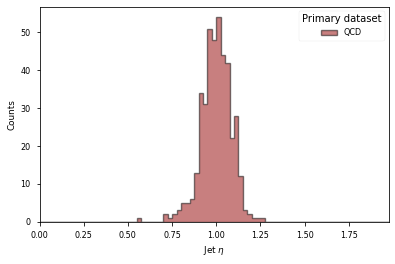

In [59]:
# N = histo.integrate('ptresponse').values()[('QCD',)]
# histo = histo.rebin('ptresponse', plot_response_axis)

h = np.max(yvals[:-1]);
h = h if h!=0 else 0.05
fig, ax2 = plt.subplots();
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
ax2.set_xlim(plot_pt_edges[[0,-1]])
plt.text(0.03,0.95*h,'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1],np.sqrt(arr[1,1])))
plt.text(0.03,0.88*h,'Width {0:0.3f}$\pm${1:0.3f}'.format(p2[2],np.sqrt(arr[2,2])))
plt.text(0.03,0.81*h,'Median {0:0.3f}'.format(np.median(histvals)))
plt.text(0.03,0.73*h,'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
plt.text(0.03,0.66*h,'N data = {0:0.3g}'.format(N))
ax2.legend();


### Save fit data to csv's

### Read csv


 

format for example $ 20 \text{ GeV} < p_T < 25 \text{ GeV} $ and $ 3.5 < \eta < 4.0 $


```
df = pd.read_csv('EtaBinsvsPtBinsMean.csv).set_index('etaBins')
ptBin='[20, 25)'
etaBin='[3.5, 4)'
mean = df[ptBin][etaBin]
```




In [ ]:
# df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5.csv').set_index('etaBins')

In [ ]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df_csv)

In [ ]:
print('-----'*10)
print("All done. Congrats!")